<a href="https://www.kaggle.com/code/iamamir/used-cars-purchase?scriptVersionId=118420709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/carvana/training_car.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# **Scenario**
> A US used-car-dealership company buys used-cars cheaply in online auctions and from other car sellers in order to then resell them profitably on their own platform. It's not always easy to tell if a used car is worth buying: one of the biggest challenges with used car auctions is the risk of a car having serious problems that prevent it from being resold to customers. These are so-called "lemon cars" - that is, cars that come out of the box with significant defects due to manufacturing errors that significantly affect the safety, use, or value of that car, and at the same time not in a reasonable number of repairs or within a given period can be remedied. In this case, the customer has the right to have the purchase price refunded. In addition to the acquisition costs, the wrong purchase of such "lemon cars" leads to considerable follow-up costs, such as the storage and repair of the car, which can result in losses when the vehicle is resold.

> That's why it's important to the company to rule out as many bad purchases of "lemon cars" as possible. In order to relieve the buyers in the company with the huge number of offers, a model should be developed that predicts whether an offer would be a bad buy in the sense of a lemon car. However, this must not lead to too many good purchases being excluded. 



# 1) Dataset Description 

In [7]:
# Import and read data dictionary to get familiar with data coumn names and their description.
import pandas as pd 
data_dict = pd.read_csv('/kaggle/input/used-cars-purchase-data-dict/used_cars_purchase_data_dict.csv', index_col = 'Column No.')
data_dict

,Column name,Description
Column No.,,
1,'RefID',Unique (sequential) number assigned to vehicles
2,'IsBadBuy',Identifies if the kicked vehicle was an avoida...
3,'PurchDate',The Date the vehicle was Purchased at Auction
4,'Auction',Auction provider at which the vehicle was purc...
5,'VehYear',The manufacturer's year of the vehicle
6,'VehicleAge',The Years elapsed since the manufacturer's year
7,'Make',Vehicle Manufacturer
8,'Model',Vehicle Model
9,'Trim',Vehicle Trim Level


# 2) Define Metric 
#### With our understanding of the problem, we should now consider which metric(s) are best suited to assess the success of our model.

#### 1. Recall: Percentage of vehicles correctly predicted as lemon cars relative to all actual lemon cars.
#### 2. Precision: Percentage of vehicles correctly predicted as lemon cars relative to all correct predictions.
#### 3. F1 Score: Weighted harmonic mean of precision and recall.

#### Goal: Exclude as many bad purchases of "lemon cars" as possible. Minimize the false negative rate, i.e. the maximum recall.
#### However, this should not mean that too many good purchases are excluded (minimum false positive).
#### The false positive rate must not be too high either.
#### The f1 score takes into account both miss rates and is the metric we are looking for.

# 3) Gather Data
#### The data is in the data_train.csv file. The target vector is given by the 'IsBadBuy' column. Here the modules that typically is needed for reading and exploration is imported and then is read in pandas DataFrame df_train.

In [8]:
#Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.2f}'.format

In [9]:
#Read data
df_train = pd.read_csv('/kaggle/input/carvana/training_car.csv')

# Copy initial dataframe (df_train)
# for further data processing comparison 
df_init = df_train.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

# 4) Exploratory Data Analysis (EDA)
## Understand Data
#### It is necessary to familiarize with the data at the beginning so that we know later what to look for while cleaning and preparing the data.

In [10]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Check first five rows of data
df_train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.00,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.00,9829.00,11636.00,13600.00,7451.00,8552.00,11597.00,12409.00,NaN,NaN,21973,33619,FL,7100.00,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.00,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.00,8383.00,10897.00,12572.00,7456.00,9222.00,11374.00,12791.00,NaN,NaN,19638,33619,FL,7600.00,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.00,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.00,4760.00,6943.00,8457.00,4035.00,5557.00,7146.00,8702.00,NaN,NaN,19638,33619,FL,4900.00,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.00,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.00,2675.00,4658.00,5690.00,1844.00,2646.00,4375.00,5518.00,NaN,NaN,19638,33619,FL,4100.00,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.00,Covers,69367,AMERICAN,COMPACT,FORD,3913.00,5054.00,7723.00,8707.00,3247.00,4384.00,6739.00,7911.00,NaN,NaN,19638,33619,FL,4000.00,0,1020


In [11]:
#check describe
df_train.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.00,72983.00,72983.00,72983.00,69814.00,72983.00,72965.00,72965.00,72965.00,72965.00,72668.00,72668.00,72668.00,72668.00,72983.00,72983.00,72983.00,72983.00,72983.00
mean,36511.43,0.12,2005.34,4.18,1.49,71500.00,6128.91,7373.64,8497.03,9850.93,6132.08,7390.68,8775.72,10145.39,26345.84,58043.06,6730.93,0.03,1276.58
std,21077.24,0.33,1.73,1.71,0.52,14578.91,2461.99,2722.49,3156.29,3385.79,2434.57,2686.25,3090.70,3310.25,25717.35,26151.64,1767.85,0.16,598.85
min,1.00,0.00,2001.00,0.00,0.00,4825.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,835.00,2764.00,1.00,0.00,462.00
25%,18257.50,0.00,2004.00,3.00,1.00,61837.00,4273.00,5406.00,6280.00,7493.00,4275.00,5414.00,6536.00,7784.00,17212.00,32124.00,5435.00,0.00,837.00
50%,36514.00,0.00,2005.00,4.00,1.00,73361.00,6097.00,7303.00,8444.00,9789.00,6062.00,7313.00,8729.00,10103.00,19662.00,73108.00,6700.00,0.00,1155.00
75%,54764.50,0.00,2007.00,5.00,2.00,82436.00,7765.00,9021.00,10651.00,12088.00,7736.00,9013.00,10911.00,12309.00,22808.00,80022.00,7900.00,0.00,1623.00
max,73014.00,1.00,2010.00,9.00,3.00,115717.00,35722.00,36859.00,39080.00,41482.00,35722.00,36859.00,39080.00,41062.00,99761.00,99224.00,45469.00,1.00,7498.00


In [12]:
# Determine different datatype column names

# Datetime
date_time = ['PurchDate']

# Categorical data
cat_cols = ['IsBadBuy','Auction','Make','Model','Trim','SubModel','Color','Transmission','WheelTypeID','WheelType',
           'Nationality','Size','TopThreeAmericanName','PRIMEUNIT','AUCGUART','BYRNO','VNZIP1','VNST','IsOnlineSale']

# Numerical data
num_cols = ['VehYear','VehicleAge','VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice',
           'MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice',
           'VehBCost','WarrantyCost']

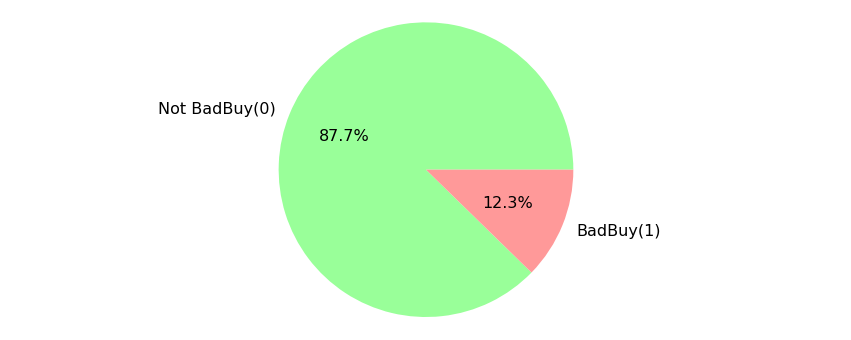

In [13]:
# Get an idea of target category: IsBadBuy
plt.figure(figsize=(15,6))
badbuy_share = df_train["IsBadBuy"].value_counts()
mylabel=["Not BadBuy(0)","BadBuy(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(badbuy_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");

#### Note target categories are strongly imbalanced.
#### The <a href="https://encord.com/blog/an-introduction-to-balanced-and-imbalanced-datasets-in-machine-learning#:~:text=The%20problem%20with%20a%20model%20trained%20on%20imbalanced%20data%20is%20that%20the%20model%20learns%20that%20it%20can%20achieve%20high%20accuracy%20by%C2%A0%20consistently%20predicting%20the%20majority%20class%2C%20even%20if%20recognizing%20the%20minority%20class%20is%20of%20equal%20or%20more%20importance%20when%20applying%20the%20model%20to%20a%20real%2Dworld%20scenario.%C2%A0">problem</a> with a model trained on imbalanced data is that the model learns that it can achieve high accuracy by  consistently predicting the majority class, even if recognizing the minority class is of equal or more importance when applying the model to a real-world scenario.

In [14]:
# Check the percentage of the missing values

percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
PRIMEUNIT,95.32
AUCGUART,95.32
WheelType,4.35
WheelTypeID,4.34
Trim,3.23
MMRCurrentAuctionAveragePrice,0.43
MMRCurrentRetailCleanPrice,0.43
MMRCurrentRetailAveragePrice,0.43
MMRCurrentAuctionCleanPrice,0.43
MMRAcquisitionAuctionAveragePrice,0.02


#### As can be seen above, more than 95% values of 'PRIMEUNIT' and 'AUCGUART' are missing. This coulmns can be ignored for the analysis.

In [15]:
# Function dropRemarks
drop_cols = pd.DataFrame(columns=['Drop Remarks'])
def dropRemarks(df,col,remark):
    '''
    Function dropRemarks collects all columns which are goingHow many unique values 
    are in the columns? How common are the respective values  for columns with only a few unique values?
    to be dropped in this analysis. It provides their related remakrks.
    Input:  DataFrame, column name as strng, Remark as string
    output: Dataframe 
    '''
    if col not in drop_cols.index.tolist():
        new_drop = pd.DataFrame(remark,index =[col], columns=['Drop Remarks'])
        return drop_cols.append(new_drop)

In [16]:
# Apply dropRemarks for PRIMEUNIT and AUCGUART
drop_cols = dropRemarks(drop_cols,'PRIMEUNIT','More than 95% of data is missing')
drop_cols = dropRemarks(drop_cols,'AUCGUART','More than 95% of data is missing')
drop_cols = dropRemarks(drop_cols,'RefId','Less likely to contribute the predictability of the model')

drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...


In [17]:
# Check data correlation: Sort most highly correlated values
display(df_train.corr()['IsBadBuy'].sort_values())

# Correlation heatmap
# Colormap: Most negative correlations (dark-blue) to most positive correlation (dark red)
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

VehYear                             -0.16
MMRAcquisitionAuctionAveragePrice   -0.11
MMRCurrentAuctionAveragePrice       -0.11
MMRCurrentAuctionCleanPrice         -0.10
MMRCurrentRetailAveragePrice        -0.10
MMRAcquisitionAuctionCleanPrice     -0.10
MMRCurrentRetailCleanPrice          -0.10
VehBCost                            -0.10
MMRAcquisitionRetailAveragePrice    -0.09
MMRAcquisitonRetailCleanPrice       -0.08
BYRNO                               -0.06
WheelTypeID                         -0.04
IsOnlineSale                        -0.00
VNZIP1                               0.01
RefId                                0.02
WarrantyCost                         0.05
VehOdo                               0.08
VehicleAge                           0.17
IsBadBuy                             1.00
Name: IsBadBuy, dtype: float64

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
RefId,1.000000,0.023973,0.010580,-0.025404,0.013110,-0.026553,-0.011568,-0.015704,-0.032208,-0.034324,-0.008742,-0.013015,-0.021616,-0.024369,0.032896,0.131898,-0.011873,-0.048851,-0.023478
IsBadBuy,0.023973,1.000000,-0.158886,0.167164,-0.044620,0.082560,-0.109252,-0.102954,-0.087418,-0.083665,-0.109112,-0.104020,-0.103914,-0.100245,-0.061488,0.005796,-0.099911,-0.003697,0.052319
VehYear,0.010580,-0.158886,1.000000,-0.957957,0.259660,-0.283719,0.581146,0.532927,0.581191,0.539230,0.590820,0.548426,0.598490,0.558669,0.280791,0.068276,0.349965,0.057380,-0.268696
VehicleAge,-0.025404,0.167164,-0.957957,1.000000,-0.250801,0.319794,-0.565690,-0.518810,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.268269,-0.074857,-0.312329,-0.024771,0.259310
WheelTypeID,0.013110,-0.044620,0.259660,-0.250801,1.000000,-0.213558,-0.095471,-0.129597,-0.072700,-0.102019,-0.088597,-0.121211,-0.074420,-0.102488,0.187199,0.007901,-0.162826,-0.006747,-0.132798
VehOdo,-0.026553,0.082560,-0.283719,0.319794,-0.213558,1.000000,-0.017022,0.024617,0.031306,0.063165,-0.028568,0.012107,0.015811,0.048005,-0.288456,-0.053041,-0.062008,0.029556,0.411718
MMRAcquisitionAuctionAveragePrice,-0.011568,-0.109252,0.581146,-0.565690,-0.095471,-0.017022,1.000000,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.107734,0.045694,0.789840,0.038818,-0.050417
MMRAcquisitionAuctionCleanPrice,-0.015704,-0.102954,0.532927,-0.518810,-0.129597,0.024617,0.990347,1.000000,0.902718,0.918242,0.923610,0.932114,0.860716,0.871203,0.062502,0.040675,0.781516,0.038667,-0.020644
MMRAcquisitionRetailAveragePrice,-0.032208,-0.087418,0.581191,-0.460854,-0.072700,0.031306,0.910391,0.902718,1.000000,0.990201,0.851647,0.849407,0.913108,0.906054,0.107516,0.035489,0.746126,0.080627,-0.053444
MMRAcquisitonRetailCleanPrice,-0.034324,-0.083665,0.539230,-0.426382,-0.102019,0.063165,0.910187,0.918242,0.990201,1.000000,0.846914,0.855689,0.903188,0.906810,0.069676,0.031284,0.744966,0.077670,-0.026933


#### Correlation is a very useful technique to get rid of unecessary columns from our dataset that don't affect our target.
#### The Pearson correlation heatmap above gives us an idea about covariance in the dataset. From what we can see the cost variables ar ehighly correlated, we will make a note of this and investigate whether we need to drop these later.

In [18]:
def simpleBarPlot(df,col,n,m,title):
    '''
    Function simpleBarPlot: 
    Output: Two bar plots - normilized and not normilized
    Input:  DataFrame, Column name, n:m: subplot dimension
           ,Plot Title 
    
    '''
    display(pd.crosstab(columns=df[col], index=df['IsBadBuy']))    
    print('\n################# Plot ',title,' #################')
    print('\n################# Number of unique values: ',
          df[col].nunique(),'#################\n')
    fig, ax = plt.subplots(nrows=n,ncols=m,figsize=(20,12))
    
    freq = pd.crosstab(index=df[col],
                               columns=df['IsBadBuy'], normalize='index')
    freq.plot(kind='bar',ax=ax[0],legend=False,figsize=(20,6),fontsize=16);
   
    count_plot = pd.crosstab(index=df[col],
                           columns=df['IsBadBuy'])    
    count_plot.plot(kind='bar',ax=ax[1],legend=False,figsize=(20,6),fontsize=16);
    
    
    ax[0].set_title(title, fontsize=20)
    ax[0].set_xlabel(col, fontsize=16)
    ax[0].set_ylabel('Frequency', fontsize=16)
    ax[0].legend(labels=['No','Yes'], title= 'Lemon car')
    
    ax[1].set_title(title, fontsize=20)
    ax[1].set_xlabel(col, fontsize=16)
    ax[1].set_ylabel('Count', fontsize=16)
    ax[1].legend(labels=['No','Yes'], title= 'Lemon car')
    fig.tight_layout();    

In [19]:
def simpleHistPlot(df,col,title,density):
    '''
    Function simpleHistPlot: 
    Output: Two Histogram plots - normilized and not normilized
    Input:  DataFrame, Column name, n:m: subplot dimension
           , Plot Title   
    
    '''
   # display(df.groupby(('IsBadBuy')[col].count())) 
    fig, ax = plt.subplots(figsize=(10,6))
    df.groupby('IsBadBuy')[col].plot(kind='hist',legend=True,
                                     figsize=(20,6),fontsize=16,
                                      alpha=0.6, density=density);  
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.legend(labels=['No','Yes'], title= 'Lemon cars')

Model,1500 RAM PICKUP 2WD,1500 RAM PICKUP 4WD,1500 SIERRA PICKUP 2,1500 SIERRA PICKUP 4,1500 SILVERADO PICKU,1500HD SIERRA PICKUP,1500HD SILVERADO PIC,2500 RAM PICKUP 2WD,2500 RAM PICKUP 4WD,2500 SILVERADO PICKU,2500HD SIERRA PICKUP,2500HD SILVERADO PIC,3.2 CL,3.2 CL 3.2L V 6 NA S,3.2 TL,3.2 TL 3.2L V6 EFI,3.2 TL 3.2L V6 FI DO,300,300 2.7L V6 MPI,300 3.5L / 6.0L V12,300 3.5L V6 MPI,300 3.5L V6 MPI / SM,300C,300C 5.7L V8 SFI,300C 5.7L V8 SFI / S,300M,300M 3.5L V6 MPI,300M 3.5L V6 MPI HO,350Z,350Z 3.5L V6 MPI,350Z MFI V6 3.5L DOH,4 RUNNER 2WD V6,4 RUNNER 2WD V6 3.4L,4 RUNNER 2WD V8,4 RUNNER 2WD V8 4.7L,4 RUNNER 4WD V6,4 RUNNER 4WD V6 3.4L,626 4C,626 4C 2.0L I-4 EFI,626 4C 2.0L I4 EFI,626 V6,626 V6 2.5L V6 EFI D,ACCENT,ACCENT 1.5L I-4 EFI,ACCENT 1.6L I-4 MPI,ACCENT 1.6L I4 MPI,ACCENT MFI I-4 1.6L,ACCORD 4C,ACCORD 4C 2.3L I-4 E,ACCORD 4C 2.3L I-4 S,ACCORD 4C 2.3L I4 EF,ACCORD 4C 2.4L I-4 M,ACCORD 4C 2.4L I4 MP,ACCORD 4C MFI I-4 2.,ACCORD V6,ACCORD V6 3.0L V6 EF,AERIO,AERIO 2.0L I4 EFI,AERIO 2.3L I-4 SFI D,AERIO 2.3L I4 DI / S,AERIO 2.3L I4 SFI,AERIO AWD,ALERO 4C,ALERO 4C 2.2L I-4 MP,ALERO 4C 2.2L I4 MPI,ALERO 4C 2.4L I-4 SF,ALERO 4C 2.4L I4 SFI,ALERO V6,ALERO V6 3.4L V6 MPI,ALTIMA,ALTIMA 2.4L I4 EFI,ALTIMA 2.5L I-4 EFI,ALTIMA 2.5L I4 EFI,ALTIMA 2.5L I4 MPI,ALTIMA 2.5L I4 MPI /,ALTIMA 3.5L V6 MPI,ALTIMA 3.5L V6 MPI /,ALTIMA MFI I-4 2.5L,ALTIMA MFI V6 3.5L D,ALTIMA Multiple Engi,AMANTI,AMANTI 3.5L V6 MPI,ARMADA 2WD V8,ARMADA 4WD V8,ASCENDER 2WD 6C,ASCENDER 2WD 6C 4.2L,ASCENDER 2WD V8 5.3L,ASCENDER 4WD 6C,ASCENDER 4WD 6C 4.2L,ASPEN 2WD V8,AURA,AURA 3.5L V6 SFI,AURA 4C,AURA V6,AURA V6 3.5L V6 SFI,AVALANCHE 1500 2WD V,AVALANCHE 1500 4WD V,AVALANCHE 2500 2WD V,AVALON,AVALON 3.0L V6 EFI,AVALON 3.0L V6 EFI D,AVALON 3.5L V6 EFI,AVENGER,AVENGER 4C,AVENGER 4C 2.4L I4 S,AVENGER V6,AVENGER V6 2.7L V6 M,AVENGER V6 Unspecifi,AVEO,AVEO 1.6L I-4 EFI DO,AVEO 1.6L I-4 MPI DO,AVEO 1.6L I4 DOHC,AVEO 1.6L I4 EFI,AVEO 1.6L I4 EFI / M,AVIATOR 2WD V8,AVIATOR 2WD V8 4.6L,AVIATOR AWD V8,AXIOM 2WD V6,AXIOM 2WD V6 3.5L V6,AXIOM 4WD V6 3.5L V6,AZERA,AZERA 3.8L V6 MPI,B2300 PICKUP 2WD 4C,B3000 PICKUP 2WD V6,B3000 PICKUP 4WD V6,BEETLE,BEETLE 2.0L I4 EFI,BEETLE 2.0L I4 EFI /,BEETLE 2.0L I4 MFI /,BEETLE 2.0L I4 MPI,BONNEVILLE,BONNEVILLE 3.8L V6 M,BONNEVILLE 3.8L V6 S,BRAVADA 2WD V6,BRAVADA 2WD V6 4.2L,BRAVADA AWD V6,BRAVADA AWD V6 4.2L,CALIBER,CALIBER 1.8L I4 SFI,CALIBER 2.0L I4 SFI,CAMARO V6,CAMARO V6 3.8L V6 MF,CAMRY 4C,CAMRY 4C 2.4L I-4 EF,CAMRY 4C 2.4L I-4 SF,CAMRY 4C 2.4L I4 EFI,CAMRY 4C 2.4L I4 SFI,CAMRY 4C EI I-4 2.2L,CAMRY 4C Multiple En,CAMRY SOLARA 4C,CAMRY SOLARA 4C 2.4L,CAMRY SOLARA 4C Mult,CAMRY SOLARA V6,CAMRY SOLARA V6 3.0L,CAMRY SOLARA V6 3.3L,CAMRY V6,CAMRY V6 3.0L / 3.3L,CAMRY V6 3.0L /3.3L,CAMRY V6 3.0L V6 EFI,CAMRY V6 3.0L V6 SFI,CAMRY V6 3.5L V6 SFI,CANYON PICKUP 2WD 4C,CANYON PICKUP 2WD I5,CANYON PICKUP 4WD I5,CARAVAN,CARAVAN FWD 4C,CARAVAN FWD 4C 2.4L,CARAVAN FWD V6,CARAVAN FWD V6 3.3L,CARAVAN GRAND AWD V6,CARAVAN GRAND FWD V6,CARAVAN SE,CAVALIER 4C,CAVALIER 4C 2.2L I 4,CAVALIER 4C 2.2L I-4,CAVALIER 4C 2.2L I4,CAVALIER 4C 2.4L I-4,CELICA,CENTURY V6,CENTURY V6 3.1L V6 S,CHARGER,CHARGER 2.7L V6 MPI,CHARGER 3.5L V6 EFI,CHARGER V6,CHARGER V6 2.7L V6 M,CHARGER V6 3.5L V6 E,CHEROKEE 2WD 6C,CHEROKEE 2WD 6C 4.0L,CHEROKEE 4WD 6C,CHEROKEE 4WD 6C 4.0L,CIVIC,CIVIC 1.7L I-4 MPI S,CIVIC 1.7L I4 MFI /,CIVIC 1.7L I4 MPI,CIVIC MFI I-4 1.7L S,COBALT,COBALT 2.2L I-4 MPI,COBALT 2.2L I4 MPI,COBALT 2.2L I4 MPI /,COLORADO PICKUP 2WD,COLORADO PICKUP 4WD,COMMANDER,COMMANDER 2WD V6,COMMANDER 2WD V6 3.7,COMMANDER 2WD V8,COMMANDER 2WD V8 4.7,COMMANDER 4WD V6,COMMANDER 4WD V6 3.7,COMMANDER 4WD V8,COMMANDER 4WD V8 4.7,COMPASS 2WD 4C,COMPASS 2WD 4C 2.0L,COMPASS 2WD 4C 2.4L,COMPASS 4WD 4C,COMPASS 4WD 4C 2.4L,COMPASS FWD 4C,CONCORDE,CONCORDE 2.7L V6 SFI,CONCORDE 3.2L V6 EFI,CONCORDE 3.5L V6 MPI,CONTINENTAL,CONTINENTAL 4.6L V8,COOPER,COOPER 1.6L I-4 EFI,COOPER 1.6L I4 EFI,COOPER S,COOPER S 1.6L I4 EFI,COROLLA,COROLLA 1.8L I-4 EFI,COROLLA 1.8L I4 EFI,COROLLA Multiple Eng,COUP


################# Plot  Vehicle Model  #################

################# Number of unique values:  1063 #################



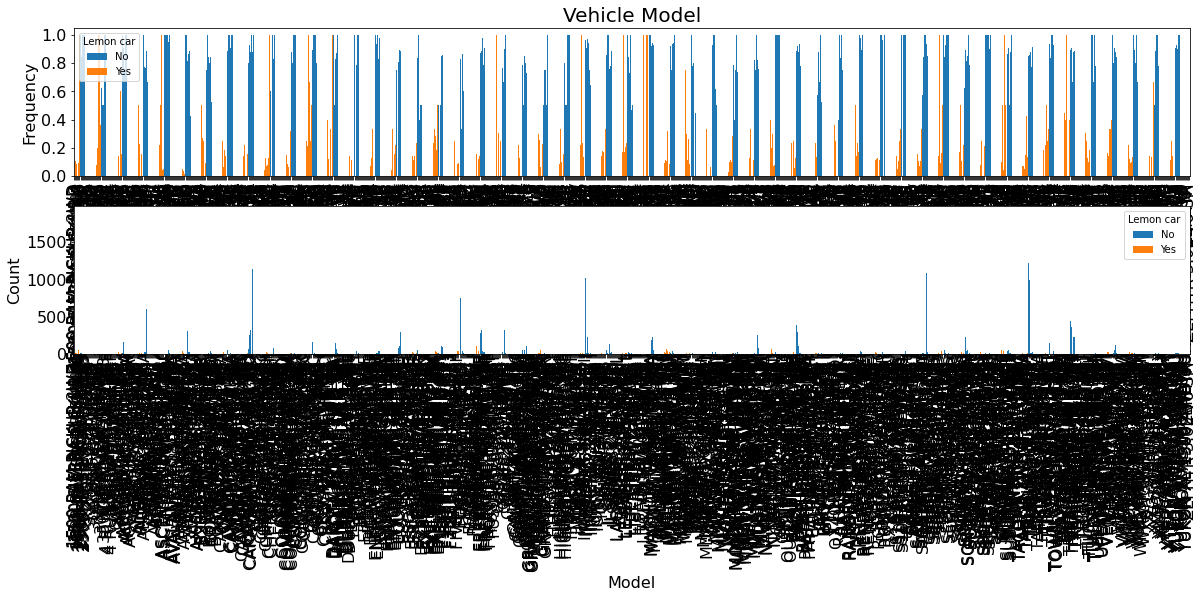

In [20]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'Model',2,1,'Vehicle Model')

SubModel,2D CONVERTIBLE,2D CONVERTIBLE DREAM CRUISER,2D CONVERTIBLE GL,2D CONVERTIBLE GLS,2D CONVERTIBLE GT,2D CONVERTIBLE GTC,2D CONVERTIBLE LIMITED,2D CONVERTIBLE LX,2D CONVERTIBLE LXI,2D CONVERTIBLE SE,2D CONVERTIBLE SLE,2D CONVERTIBLE TOURING,2D COUPE,2D COUPE 5SP,2D COUPE AUTO,2D COUPE DX 5SP,2D COUPE DX AUTO,2D COUPE DX VALUE PACKAGE AUTO,2D COUPE EX 5SP,2D COUPE EX 6SP,2D COUPE EX AUTO,2D COUPE GL,2D COUPE GL1,2D COUPE GL2,2D COUPE GLS,2D COUPE GS,2D COUPE GT,2D COUPE GT PREMIUM,2D COUPE GT1,2D COUPE GTP,2D COUPE GTS,2D COUPE GX,2D COUPE LIMTED,2D COUPE LS,2D COUPE LT,2D COUPE LTZ,2D COUPE LX,2D COUPE LX 5SP,2D COUPE LX AUTO,2D COUPE LXI,2D COUPE R/T,2D COUPE RS,2D COUPE SE,2D COUPE SE AUTO,2D COUPE SE1,2D COUPE SS,2D COUPE SVT,2D COUPE SXT,2D COUPE TYPE S,2D COUPE TYPE S NAVIGATION AUTO,2D COUPE Z24,2D COUPE ZX2,2D COUPE ZX3,2D COUPE ZX3 S,2D COUPE ZX3 SES,2D COUPE ZX5 S,2D EXT CAB 2.3L EDGE,2D EXT CAB 2.3L XL,2D EXT CAB 3.0L,2D EXT CAB 3.0L DUAL SPORT,2D EXT CAB 3.0L DUAL SPORT FFV,2D EXT CAB 3.0L EDGE,2D EXT CAB 3.0L SE,2D EXT CAB 3.0L XL,2D EXT CAB 3.0L XLT,2D EXT CAB 4.0L EDGE,2D EXT CAB 4.0L XL,2D HARTOP CONVERTIBLE GT,2D HATCHBACK,2D HATCHBACK GS,2D HATCHBACK GT,2D HATCHBACK S,2D HATCHBACK ZX3,2D HATCKBACK SI 5SP,2D LIFTBACK GT,2D QUAD COUPE LEVEL 2,2D QUAD COUPE LEVEL 3,2D ROADSTER,2D ROADSTER GXP,2D SEDAN,2D SEDAN GX,2D SPORT UTILITY,2D SPYDER GS,2D SPYDER GT,2D SPYDER GTS,2D SUV 4.0L SPORT,2D SUV 4.0L SPORT XLS,2D SUV 4.0L SPORT XLT,2D SUV CONVERTIBLE 2.0L,3D COUPE SC1,3D COUPE SC2,3D EXT CAB 2.2L,3D EXT CAB 2.2L FFV,3D EXT CAB 4.3L,4D CROSSOVER SE,4D CROSSOVER SEL,4D CROSSOVER SEL PLUS,4D CUV,4D CUV 2.0L XLS,4D CUV 2.0L XLT,4D CUV 2.2L,4D CUV 2.2L XE,4D CUV 2.3L XLS,4D CUV 2.3L XLT,4D CUV 2.7L,4D CUV 2.7L GLS,4D CUV 3.0L,4D CUV 3.0L LIMITED,4D CUV 3.0L SE,4D CUV 3.0L SEL,4D CUV 3.0L XLS,4D CUV 3.0L XLT,4D CUV 3.5L,4D CUV 3.5L GLS,4D CUV 3.6L XE,4D CUV DELUXE,4D CUV DLX,4D CUV GL,4D CUV GLS,4D EXT CAB 3.0L,4D EXT CAB 3.0L EDGE,4D EXT CAB 3.0L FFV XLT,4D EXT CAB 3.0L XL,4D EXT CAB 3.0L XLT,4D EXT CAB 4.0L EDGE,4D EXT CAB 4.0L FX4,4D EXT CAB 4.0L XL,4D EXT CAB 4.0L XLT,4D HARDTOP EX,4D HARDTOP JLS,4D HARDTOP LX,4D HATCHBACK,4D HATCHBACK AWD,4D HATCHBACK GS,4D HATCHBACK S,4D HATCHBACK ZX5,4D HATCHBACK ZX5 S,4D HATCHBACK ZX5 SE,4D HATCHBACK ZX5 SES,4D MINIVAN 3.4L,4D MINIVAN 3.4L VALUE,4D MINIVAN EXT 3.4L,4D MINIVAN EXT 3.4L GL,4D MINIVAN EXT 3.4L GLS,4D MINIVAN EXT 3.5L,4D PASSENGER 3.8L SE,4D PASSENGER 3.8L SE SPORT,4D PASSENGER 3.8L SEL,4D PASSENGER 3.8L SEL LIMITED,4D PASSENGER 3.9L SES,4D PASSENGER 4.2L LIMITED,4D PASSENGER 4.2L SEL,4D SEDAN,4D SEDAN 1.8,4D SEDAN 1.8S,4D SEDAN 1LT,4D SEDAN 2.0L GL,4D SEDAN 2.0L GLS,4D SEDAN 2.4I,4D SEDAN 2.5 S,4D SEDAN 2.5 SE,4D SEDAN 2.5 SL,4D SEDAN 2.5I,4D SEDAN 2.5L,4D SEDAN 2.5L GLS,4D SEDAN 2.5L PKG 2,4D SEDAN 2.5RS,4D SEDAN 2.5T,4D SEDAN 2.7L,4D SEDAN 2.7L SE,4D SEDAN 2.7L SXT,4D SEDAN 3.5L,4D SEDAN 3.5L AWD,4D SEDAN 3.5L AWD SXT,4D SEDAN 3.5L SE,4D SEDAN 3.5L SXT,4D SEDAN 35TH ANNIVERSARY AWD,4D SEDAN 6SP,4D SEDAN AUTO,4D SEDAN AWD,4D SEDAN AWD 3.5L,4D SEDAN AWD SE,4D SEDAN AWD SEL,4D SEDAN CARTIER,4D SEDAN CARTIER L,4D SEDAN CE,4D SEDAN CLASSIC,4D SEDAN CUSTOM,4D SEDAN CX,4D SEDAN CXL,4D SEDAN CXS,4D SEDAN DE,4D SEDAN DX,4D SEDAN DX AUTO,4D SEDAN ES,4D SEDAN ES HIGHLINE,4D SEDAN EX,4D SEDAN EX 5SP,4D SEDAN EX AUTO,4D SEDAN EX AUTO NAVIGATION,4D SEDAN EXECUTIVE,4D SEDAN FFV TOURING,4D SEDAN GL,4D SEDAN GL1,4D SEDAN GL2,4D SEDAN GLE,4D SEDAN GLS,4D SEDAN GS,4D SEDAN GS 3.0L FFV,4D SEDAN GT,4D SEDAN GT TURBO,4D SEDAN GT1,4D SEDAN GT2,4D SEDAN GTP,4D SEDAN GTS,4D SEDAN GX,4D SEDAN GXE,4D SEDAN GXP,4D SEDAN HEMI,4D SEDAN HYBRID,4D SEDAN HYBRID AUTO,4D SEDAN I,4D SEDAN L AWD,4D SEDAN L200,4D SEDAN L300,4D SEDAN LE,4D SEDAN LEVEL 1,4D SEDAN LEVEL 2,4D SEDAN LEVEL 3,4D SEDAN LIMITED,4D SEDAN LIMITED AWD,4D SEDAN LIMITED TURBO,4D SEDAN LS,4D SEDAN LS 3.5L,4D SEDAN LS 3.5L FFV,4D SEDAN LS 3.6L,4D SEDAN LS CLASSIC,4D SEDAN LS FFV,4D SEDAN LS PREMIUM,4D SEDAN LS SPORT,4D SEDAN LT


################# Plot  Vehicle Sub-Model  #################

################# Number of unique values:  863 #################



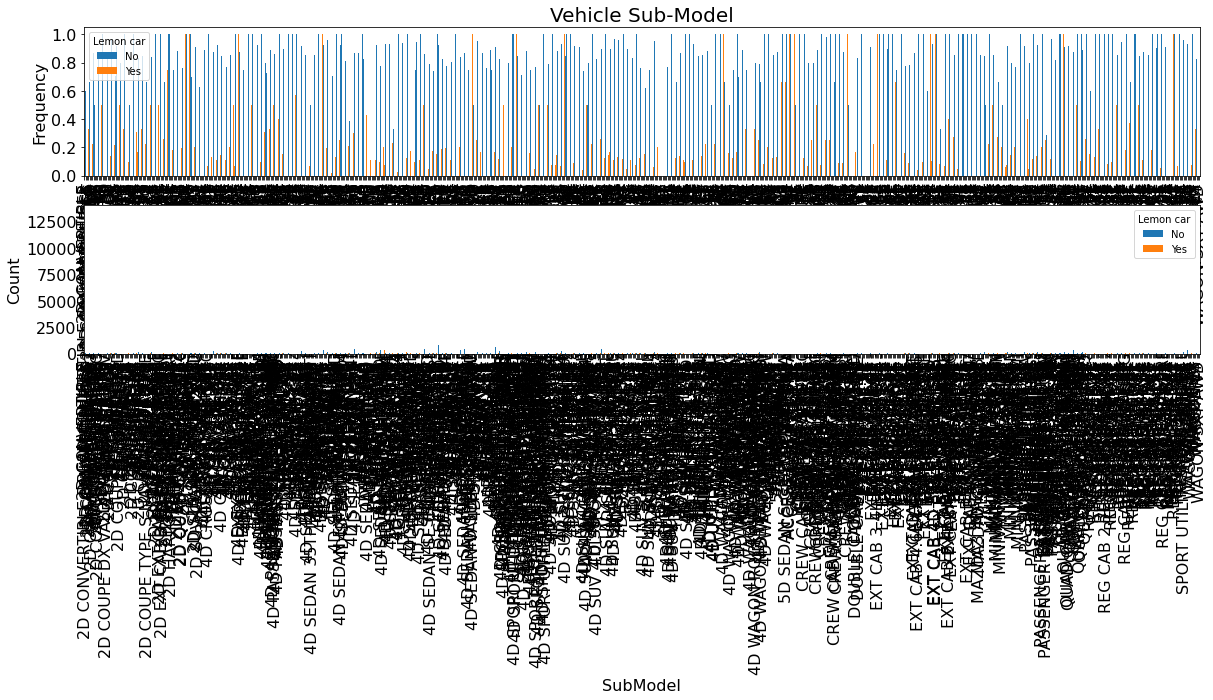

In [21]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'SubModel',2,1,'Vehicle Sub-Model')

In [22]:
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Model','Too many distincts values')
drop_cols = dropRemarks(drop_cols,'SubModel','Too many distincts values')
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values


Auction,ADESA,MANHEIM,OTHER
IsBadBuy,,,
0,12246,36328,15433
1,2193,4715,2068



################# Plot  Auction provider  #################

################# Number of unique values:  3 #################



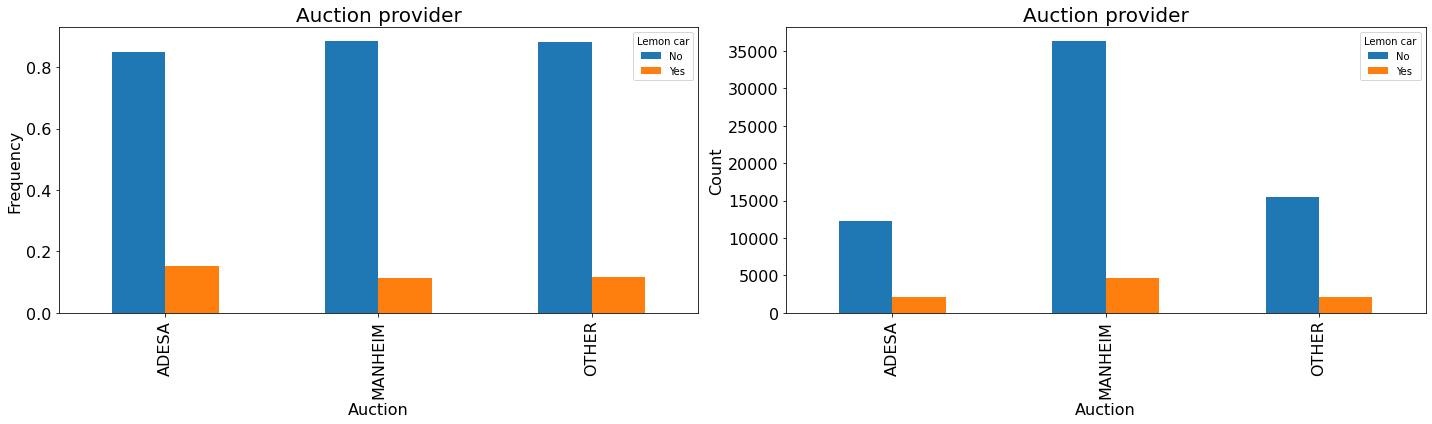

In [23]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'Auction',1,2,'Auction provider')

,VehYear,VehicleAge
VehYear,1.00,-0.96
VehicleAge,-0.96,1.00


VehicleAge,0,1,2,3,4,5,6,7,8,9
IsBadBuy,,,,,,,,,,
0,2,2969,7942,14601,15149,11061,6575,3641,1623,444
1,0,125,540,1301,1864,1895,1447,1005,597,202



################# Plot  VehicleAge  #################

################# Number of unique values:  10 #################



,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge


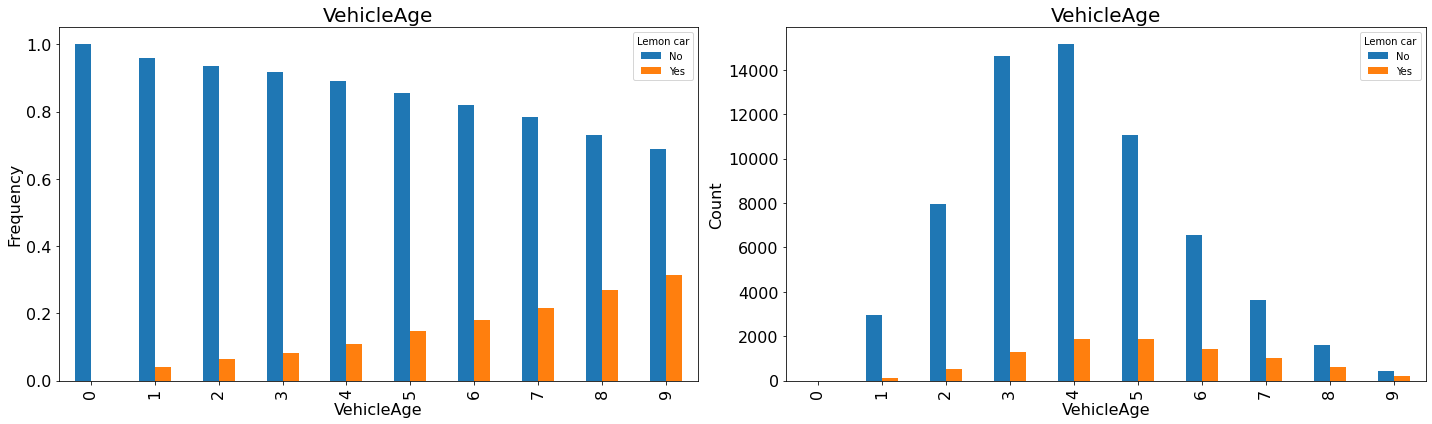

In [24]:
# Investigate VehYear and VehicleAge

# Check the correlation between Year of Manufacture
# of the vehicle Age of the car at the time of the auction
display(df_train[['VehYear','VehicleAge']].corr())

simpleBarPlot(df_train,'VehicleAge',1,2,'VehicleAge')

# Note: AS can be seen, the older the vehicle, more number of defected vehicle
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'VehYear','96% Correlation with VehicleAge')
drop_cols

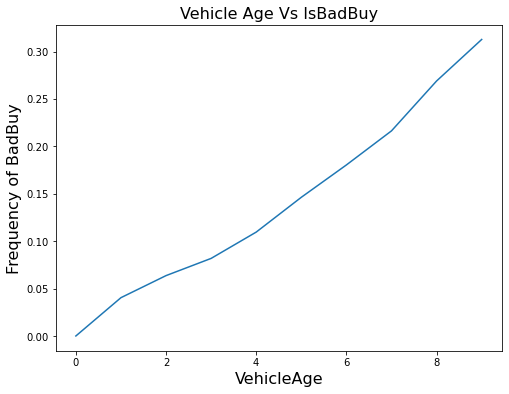

In [25]:
ax = df_train.groupby('VehicleAge')['IsBadBuy'].mean().plot(figsize=(8,6));
ax.set_xlabel('VehicleAge', fontsize=16);
ax.set_ylabel('Frequency of BadBuy', fontsize=16);
ax.set_title('Vehicle Age Vs IsBadBuy', fontsize=16 );

#### Again, as expected, we see that vehicle age is strongly indicative of a bad buy.
#### Let's look at how the vehicle manufacturer is related to the probability of a bad buy:

Make,ACURA,BUICK,CADILLAC,CHEVROLET,CHRYSLER,DODGE,FORD,GMC,HONDA,HUMMER,HYUNDAI,INFINITI,ISUZU,JEEP,KIA,LEXUS,LINCOLN,MAZDA,MERCURY,MINI,MITSUBISHI,NISSAN,OLDSMOBILE,PLYMOUTH,PONTIAC,SATURN,SCION,SUBARU,SUZUKI,TOYOTA,TOYOTA SCION,VOLKSWAGEN,VOLVO
IsBadBuy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,24,607,28,15567,7707,11579,9563,574,443,1,1578,28,125,1390,2192,20,68,821,758,16,907,1752,194,1,3751,1857,118,22,1133,1030,1,115,37
1,9,113,5,1681,1137,1333,1742,75,54,0,233,14,9,254,292,11,29,158,155,8,123,333,49,1,507,306,11,6,195,114,0,19,0



################# Plot  Company  #################

################# Number of unique values:  33 #################



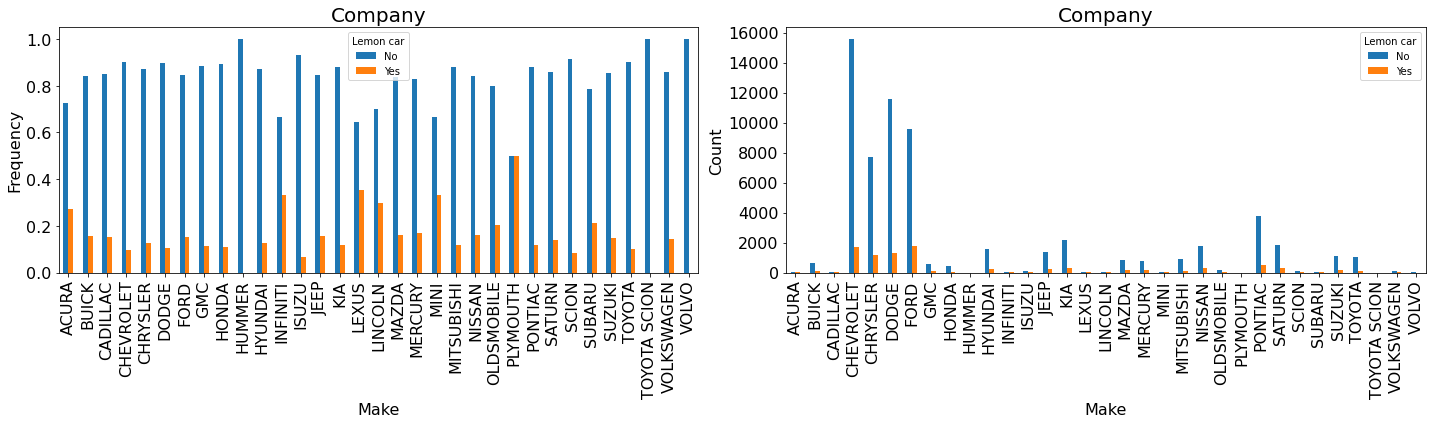

In [26]:
#simpleBarPlot(df_train,'Make','Make')
simpleBarPlot(df_train,'Make',1,2,'Company')

#### Dogde, Ford, Chevrolet and Chrysler cars account for the most listed as well as most bad buys. That makes sense. If a company has more listings, it will as well have higher bad buys.

Trim,1,150,2,250,3,3 R,Adv,Bas,C,CE,CX,CXL,CXS,Car,Cin,Cla,Cus,DE,DS,DX,Den,Dur,ES,EX,EX-,Edd,Edg,Ent,Exe,FX4,GL,GLE,GLS,GS,GT,GTC,GTP,GTS,GX,GXE,GXP,Har,Her,Hig,Hyb,JLS,JLX,Kin,L,L 3,L10,L20,L30,LE,LL,LS,LT,LTZ,LW2,LW3,LX,LXi,Lar,Lim,Lux,Max,Maz,Nor,OZ,Out,Ove,Plu,Pre,Pro,R/T,RS,RT,Ral,Ren,S,SC1,SC2,SE,SE-,SEL,SES,SL,SL1,SL2,SLE,SLT,SR5,SS,ST,STX,SV6,SVT,SX,SXT,Si,Sig,Spe,Spo,Spy,Sta,T5,Tou,Ult,VP,Val,W/T,X,XE,XL,XLS,XLT,XR,XRS,XS,Xsp,Z24,Z71,ZR2,ZTS,ZTW,ZX2,ZX3,ZX4,ZX5,ZXW,eC,eL,i,s
IsBadBuy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,155,265,650,3,163,6,208,12223,4,202,205,86,9,2,5,416,240,44,7,34,4,1,608,1861,6,178,90,4,15,8,344,10,1189,247,684,32,59,7,7,25,1,1,49,4,2,1,0,10,5,1,14,94,113,511,1,9280,3275,16,6,23,2137,78,766,801,37,15,0,393,12,0,3,14,60,9,33,5,7,2,31,537,10,15,8199,5,1231,483,52,31,29,480,1062,57,56,744,266,78,7,70,3447,3,8,5,1062,16,23,2,1952,1,21,21,91,13,189,376,610,1095,18,5,1,1,0,41,2,51,6,6,208,506,76,25,2,8,432,170
1,13,40,115,0,25,1,19,1727,3,19,25,11,0,1,2,59,59,1,1,13,2,1,92,259,2,35,18,0,4,5,66,9,166,48,124,2,7,1,0,8,2,0,9,3,1,0,1,0,3,0,4,21,28,61,0,894,265,2,2,16,280,33,136,164,4,0,1,55,2,1,2,9,5,5,11,1,0,2,5,93,6,6,1149,2,129,118,5,4,7,63,138,8,13,97,22,9,2,7,378,0,3,0,192,5,3,0,304,0,6,2,11,1,17,72,162,262,1,3,1,0,1,5,2,16,1,6,38,100,15,7,2,0,55,42



################# Plot  Trim  #################

################# Number of unique values:  134 #################



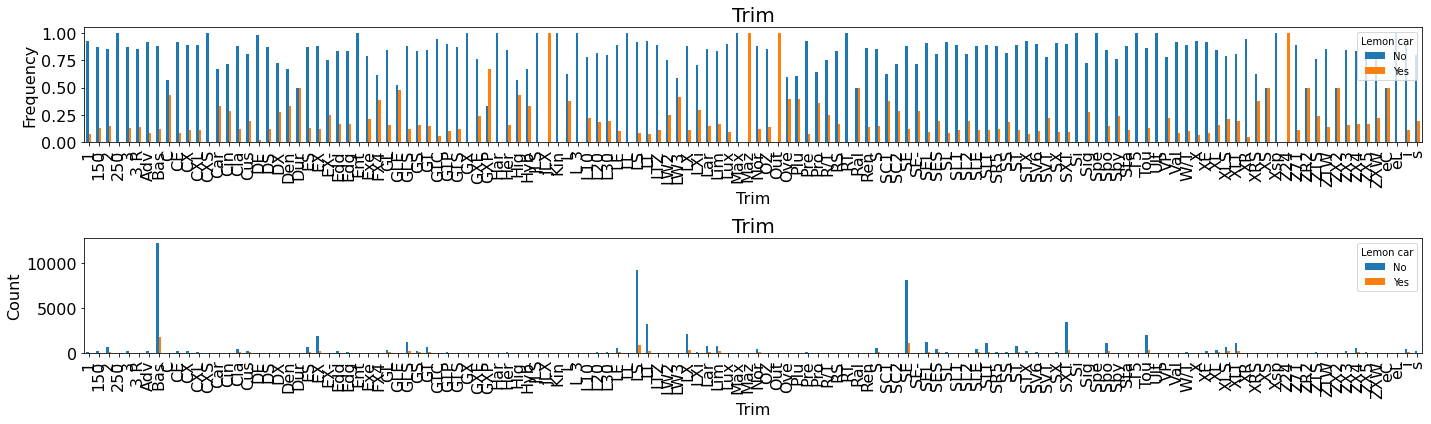

In [27]:
#simpleBarPlot(df_train,'Make','Make')
simpleBarPlot(df_train,'Trim',2,1,'Trim')

In [28]:
# Note: Too many different distinct Trim values. 
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Trim','Too many distinct values')
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values


Color,BEIGE,BLACK,BLUE,BROWN,GOLD,GREEN,GREY,MAROON,NOT AVAIL,ORANGE,OTHER,PURPLE,RED,SILVER,WHITE,YELLOW
IsBadBuy,,,,,,,,,,,,,,,,
0,1373,6769,9158,380,4494,2792,6976,1786,70,381,213,317,5432,13032,10617,210
1,211,858,1189,56,737,402,911,260,24,34,29,56,825,1843,1506,34



################# Plot  Color  #################

################# Number of unique values:  16 #################



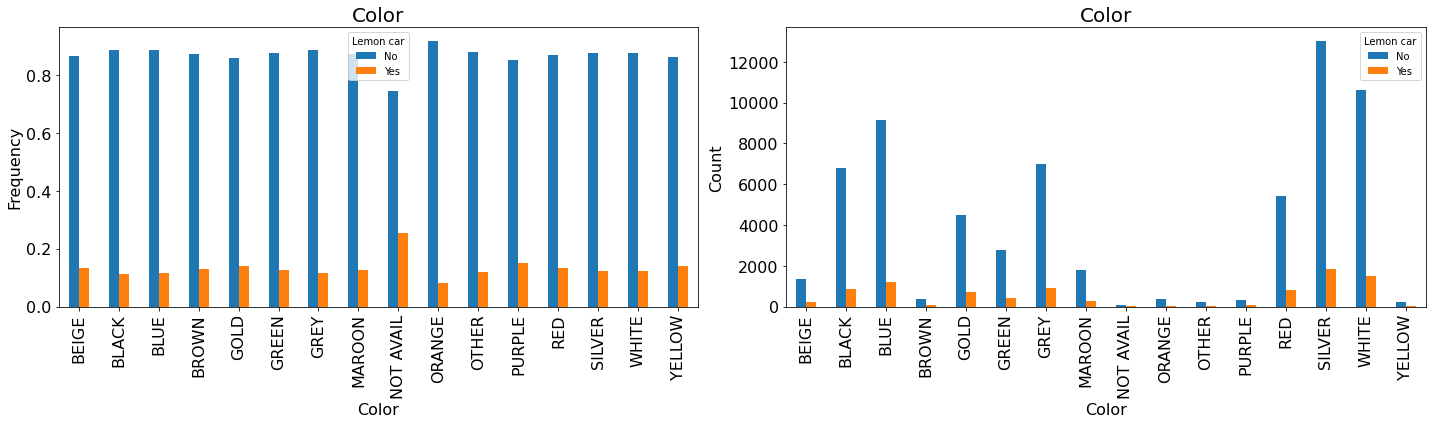

In [29]:
# Investigate Color
simpleBarPlot(df_train,'Color',1,2,'Color')

In [30]:
# Note: Too many different distinct Trim values. 
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Color','The effect is too suspicious!')
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!


Transmission,AUTO,MANUAL,Manual
IsBadBuy,,,
0,61722,2276,1
1,8676,299,0



################# Plot  Transmission  #################

################# Number of unique values:  3 #################



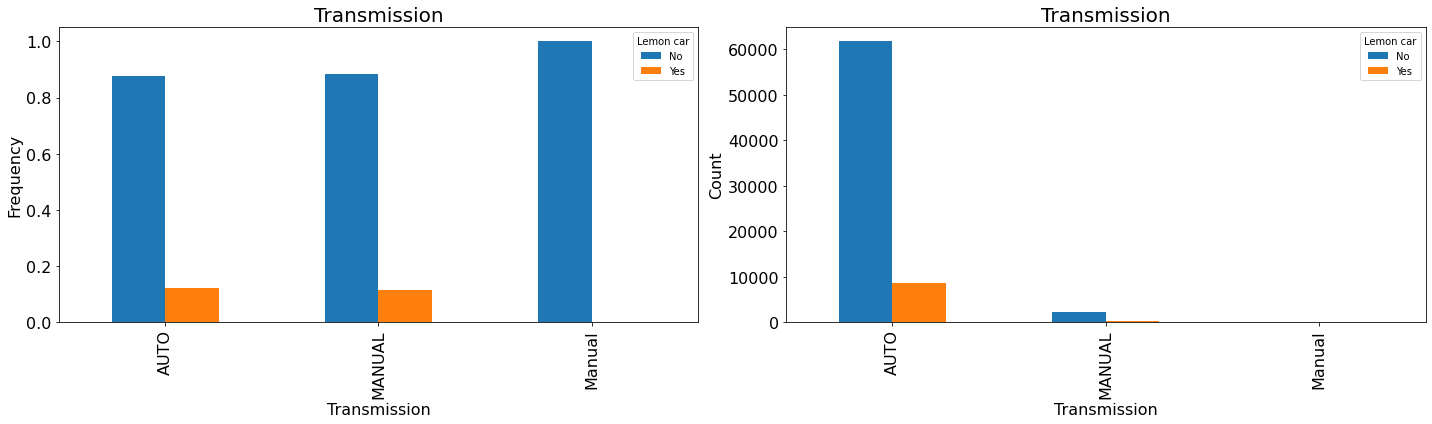

In [31]:
# Plot Transmission
simpleBarPlot(df_train,'Transmission',1,2,'Transmission')

WheelTypeID,0.00,1.00,2.00,3.00
IsBadBuy,,,,
0,4,32065,30349,656
1,1,3985,2655,99



################# Plot  WheelTypeID  #################

################# Number of unique values:  4 #################



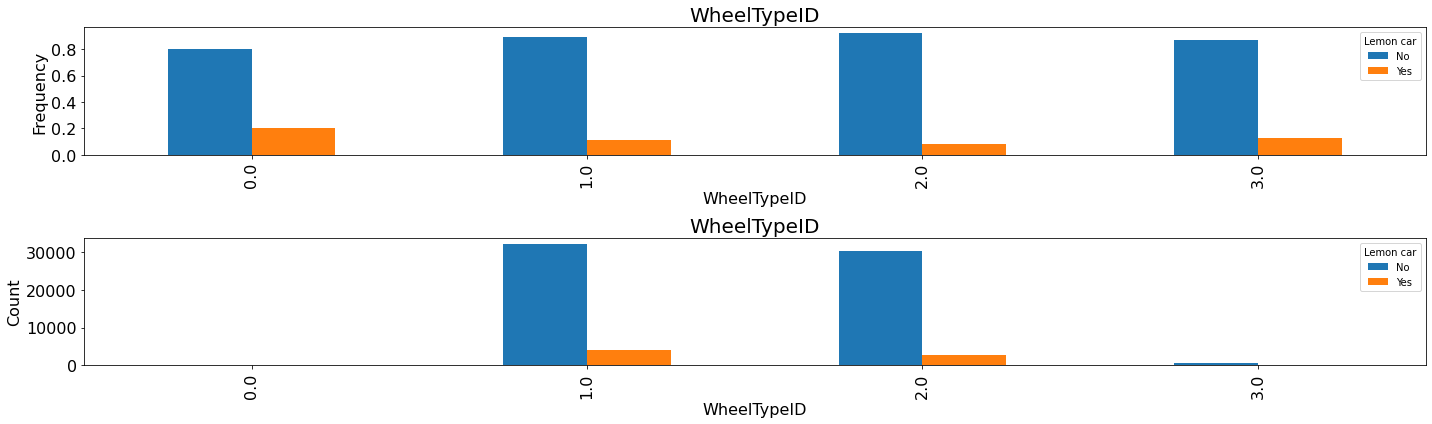

In [32]:
simpleBarPlot(df_train,'WheelTypeID',2,1,'WheelTypeID')

In [33]:
drop_cols = dropRemarks(drop_cols,'WheelTypeID','Redundant, as WheelType is available!')
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"


#### Let's look at how the WheelType is related to the probability of a bad buy


WheelType,Alloy,Covers,Special
IsBadBuy,,,
0,32065,30349,656
1,3985,2655,99



################# Plot  WheelType  #################

################# Number of unique values:  3 #################



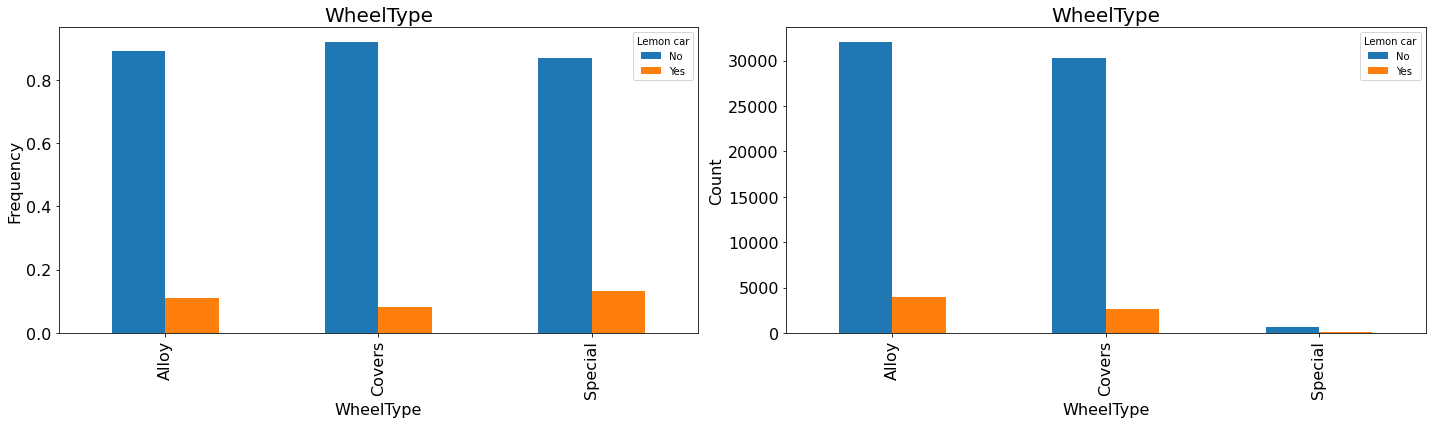

In [34]:
simpleBarPlot(df_train,'WheelType',1,2,'WheelType')

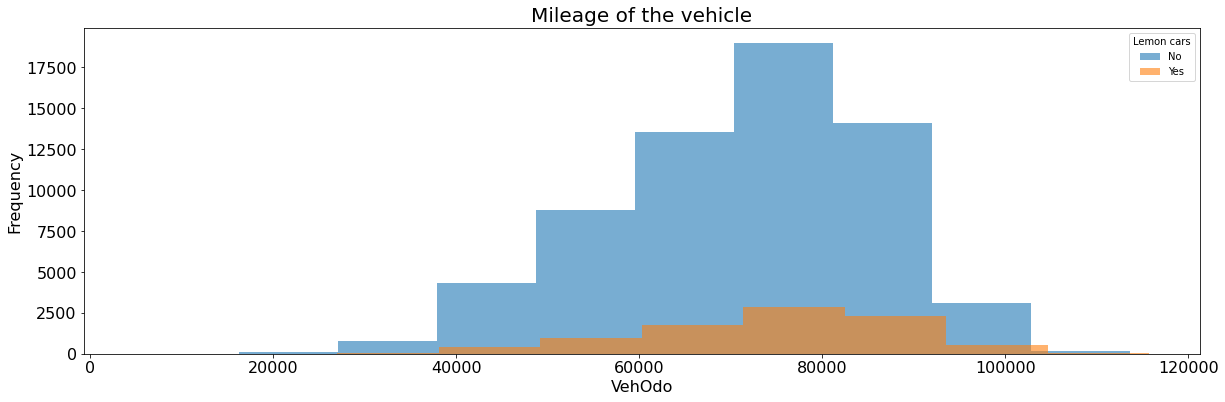

In [35]:
# Carmilage = Kms driven / Fuel consumed
simpleHistPlot(df_train,'VehOdo','Mileage of the vehicle',False)


### Plot odometer reading vs WarrantyCost

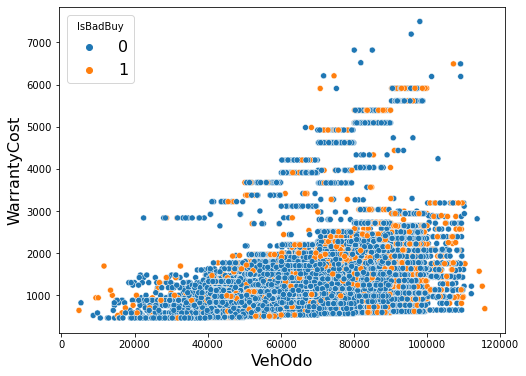

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_train, x='VehOdo',y='WarrantyCost',hue='IsBadBuy');
plt.xlabel('VehOdo', fontsize=16);
plt.ylabel('WarrantyCost', fontsize=16);
plt.legend(title='IsBadBuy', fontsize=16);

### Plot the manufacturer's country

Nationality,AMERICAN,OTHER,OTHER ASIAN,TOP LINE ASIAN
IsBadBuy,,,,
0,53641,168,6972,3221
1,7387,27,1061,501



################# Plot  Nationality  #################

################# Number of unique values:  4 #################



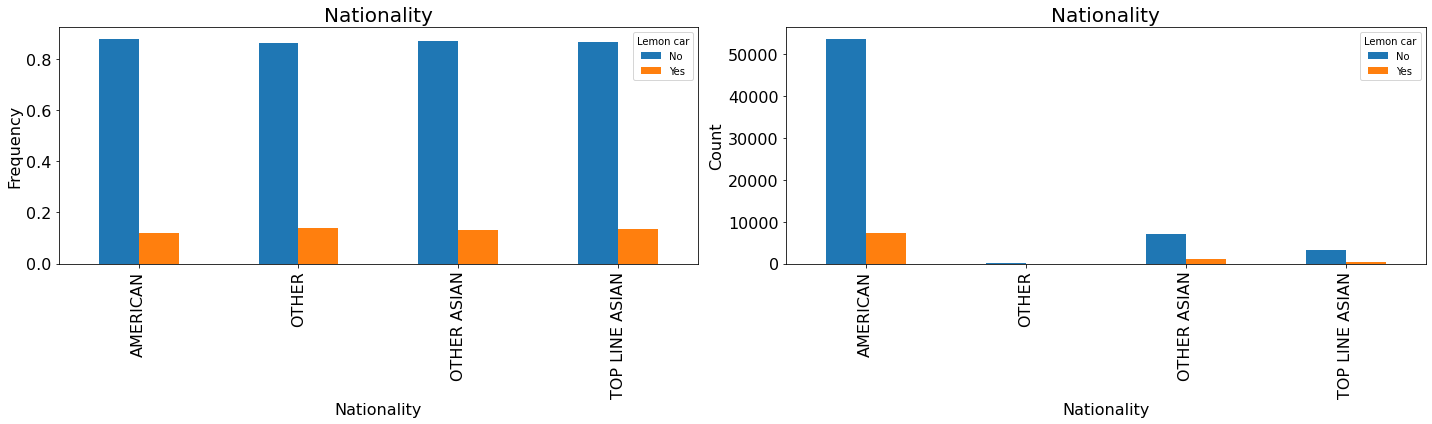

In [37]:
simpleBarPlot(df_train,'Nationality',1,2,'Nationality')

#### Identifies if the manufacturer is one of the top three American manufacturers

Nationality,AMERICAN,OTHER,OTHER ASIAN,TOP LINE ASIAN
TopThreeAmericanName,,,,
CHRYSLER,23399,0,0,0
FORD,12315,0,0,0
GM,25314,0,0,0
OTHER,0,195,8033,3722


Nationality,AMERICAN,OTHER,OTHER ASIAN,TOP LINE ASIAN
Make,,,,
ACURA,0,0,33,0
BUICK,720,0,0,0
CADILLAC,33,0,0,0
CHEVROLET,17248,0,0,0
CHRYSLER,8844,0,0,0
DODGE,12911,0,0,0
FORD,11305,0,0,0
GMC,648,0,0,0
HONDA,0,0,0,497


TopThreeAmericanName,CHRYSLER,FORD,GM,OTHER
IsBadBuy,,,,
0,20674,10389,22578,10361
1,2725,1926,2736,1589



################# Plot  TopThreeAmericanName  #################

################# Number of unique values:  4 #################



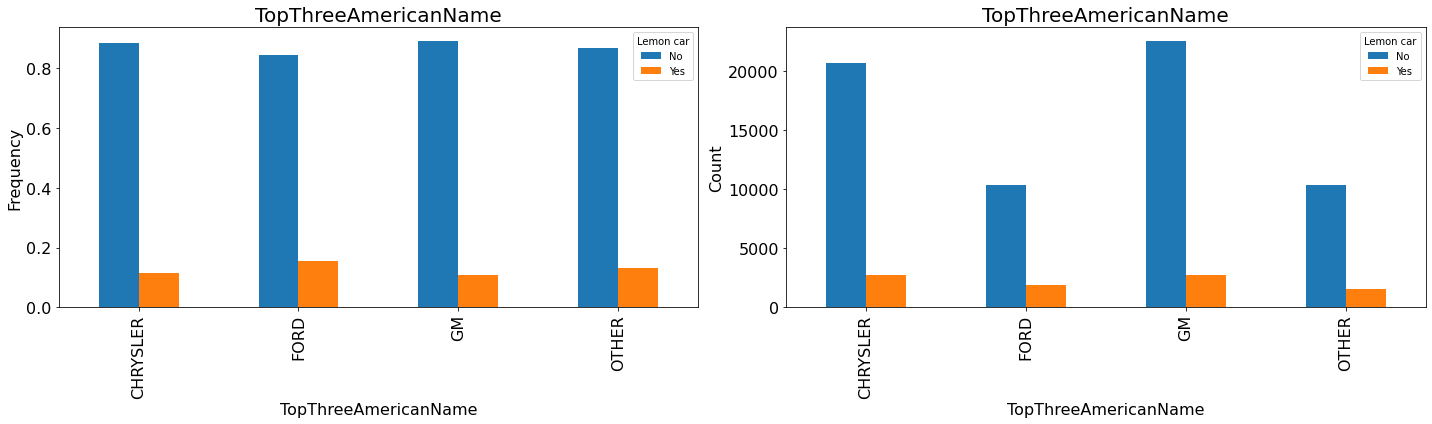

In [38]:
display(pd.crosstab(index=df_train['TopThreeAmericanName'],columns=df_train['Nationality'])) 
display(pd.crosstab(index=df_train['Make'],columns=df_train['Nationality'])) 
simpleBarPlot(df_train,'TopThreeAmericanName',1,2,'TopThreeAmericanName')

#### The size category of the vehicle (Compact, SUV, etc.)

Size,COMPACT,CROSSOVER,LARGE,LARGE SUV,LARGE TRUCK,MEDIUM,MEDIUM SUV,SMALL SUV,SMALL TRUCK,SPECIALTY,SPORTS,VAN
IsBadBuy,,,,,,,,,,,,
0,6060,1576,8032,1201,2810,27244,6897,1963,739,1739,633,5108
1,1145,183,818,232,360,3541,1193,313,125,176,144,746



################# Plot  Size  #################

################# Number of unique values:  12 #################



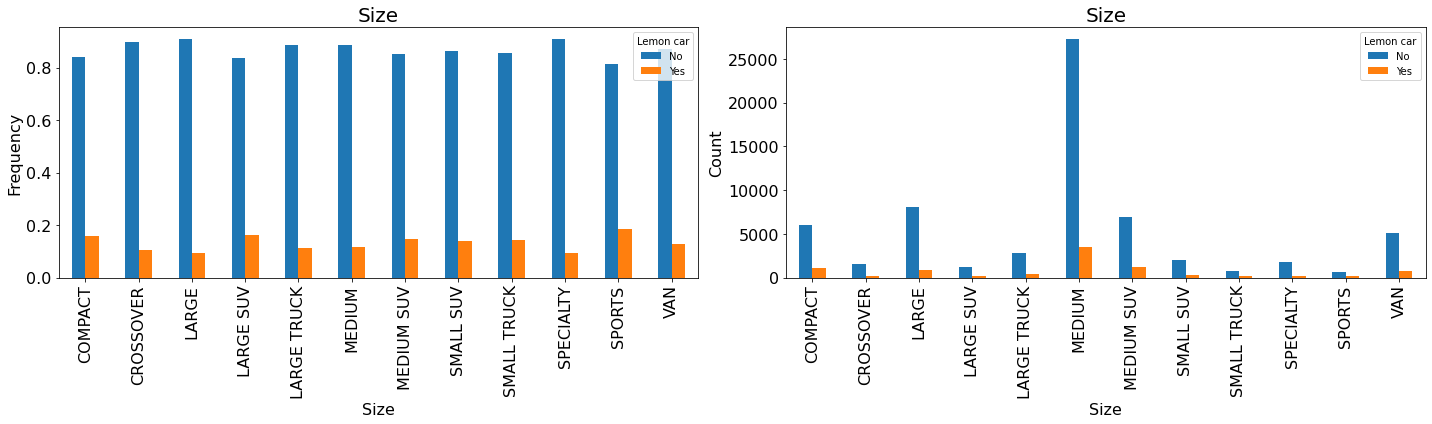

In [39]:
simpleBarPlot(df_train,'Size',1,2,'Size')

### Pair Plot of Acquisition costs

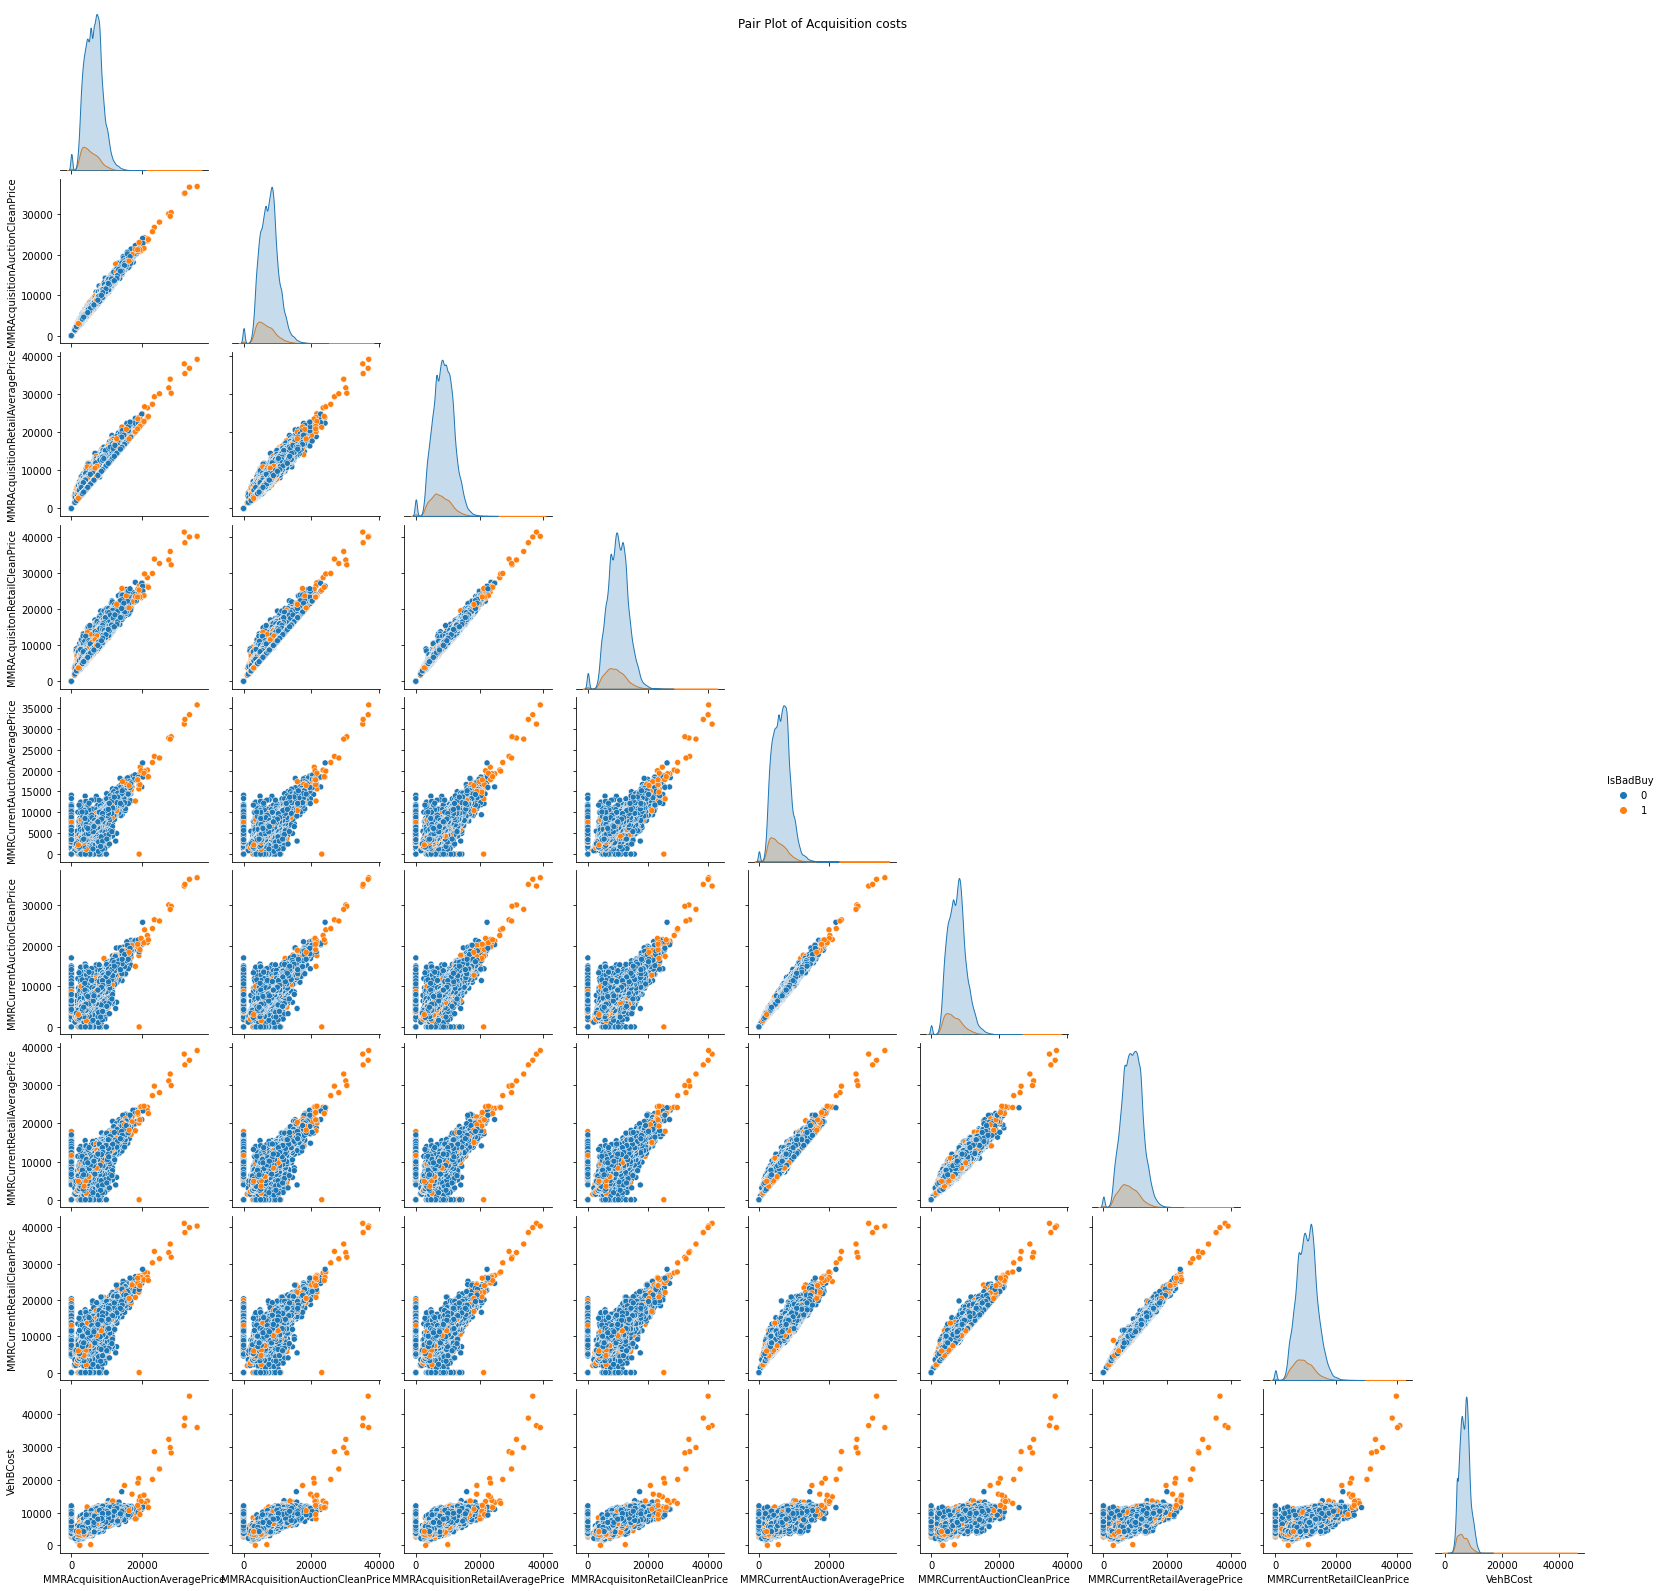

In [40]:
mmr_cols = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice',
           'MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','IsBadBuy','VehBCost']

ax=sns.pairplot(df_train[mmr_cols], hue="IsBadBuy",corner=True);
ax.fig.suptitle("Pair Plot of Acquisition costs");

In [41]:
drop_cols = dropRemarks(drop_cols,'MMRCurrentAuctionCleanPrice','About 99% correlation with MMRCurrentAuctionAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRCurrentRetailCleanPrice','About 99% correlation with MMRCurrentRetailAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRAcquisitionAuctionCleanPrice','About 99% correlation with MMRAcquisitionAuctionAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRAcquisitonRetailCleanPrice','About 99% correlation with MMRQcquisitionRetailAverageprice')
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"
MMRCurrentAuctionCleanPrice,About 99% correlation with MMRCurrentAuctionAv...


### Unique number assigned to the buyer that purchased the vehicle

BYRNO,835,1031,1035,1041,1045,1051,1055,1081,1082,1085,1086,1121,1125,1141,1151,1152,1156,1157,1191,1231,1235,3453,3582,5546,8172,8655,10310,10315,10410,10420,10425,10430,10510,11210,11410,16044,16369,16926,17212,17675,18091,18111,18822,18880,18881,19064,19619,19638,19662,20207,20234,20392,20740,20833,20928,21047,21053,21973,22808,22916,23359,23657,25100,52117,52492,52598,52644,52646,53245,99740,99741,99750,99760,99761
IsBadBuy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2630,29,9,6,49,68,12,34,7,41,1,18,10,19,62,4,9,1,92,329,425,2596,0,2000,977,1785,37,159,10,4,1,160,4,8,34,1388,7,1096,2163,2253,9,1830,1805,3047,1596,719,2420,1658,1314,1188,1835,215,2035,1635,2330,125,2439,2253,1598,2465,1726,314,1420,1088,597,528,327,296,63,299,0,2574,0,3722
1,357,2,1,2,13,5,0,3,0,9,0,3,0,2,2,2,1,0,12,60,44,331,1,211,128,287,9,16,0,0,0,21,0,0,6,243,0,232,354,364,2,285,297,541,155,105,318,195,203,163,228,40,379,363,256,25,377,295,253,387,350,43,202,160,96,59,62,51,18,44,1,79,2,221



################# Plot  BYRNO  #################

################# Number of unique values:  74 #################



,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"
MMRCurrentAuctionCleanPrice,About 99% correlation with MMRCurrentAuctionAv...


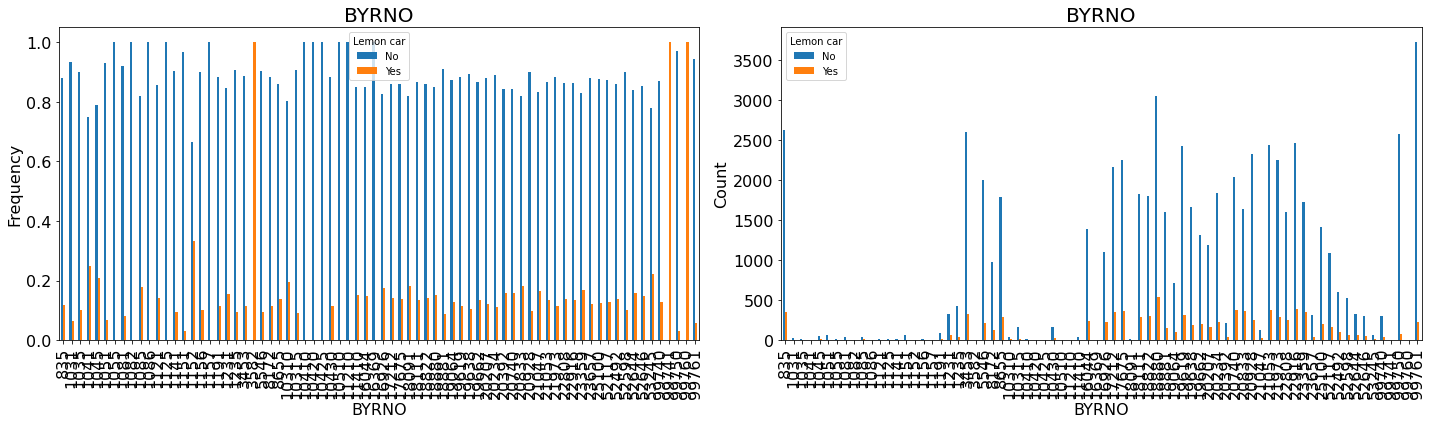

In [42]:
simpleBarPlot(df_train,'BYRNO',1,2,'BYRNO')
drop_cols = dropRemarks(drop_cols,'BYRNO','Unique Identification Number ')
drop_cols

VNZIP1,2764,3106,8505,12552,16066,16137,17028,17406,17545,19440,20166,21014,21075,22403,22801,23234,23606,25071,25177,26431,27407,27542,28273,28625,29070,29323,29461,29532,29697,30120,30212,30272,30315,30331,30529,32124,32219,32225,32503,32750,32772,32812,32824,33073,33311,33314,33411,33619,33762,33809,33916,34203,34761,35004,35613,37122,37138,37210,37421,37771,38118,38128,38637,39208,39402,42104,43207,45005,45011,46239,46803,47129,48265,50111,55369,60440,60443,60445,62207,63044,64153,64161,68138,70002,70401,70460,71119,72117,73108,73129,74135,75020,75050,75061,75236,76040,76063,76101,77041,77061,77073,77086,77301,78219,78227,78426,78610,78745,78754,79605,79932,80011,80022,80112,80229,80817,83687,83716,84087,84104,85009,85018,85040,85204,85226,85248,85260,85284,85338,85353,87105,87109,89120,89139,89165,89506,90045,90650,91752,91763,91770,92057,92101,92337,92504,92807,94544,95673,97060,97217,97402,98064,99224
IsBadBuy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13,88,277,6,6,2,33,119,100,440,458,179,814,437,467,4,33,0,142,121,483,3072,1606,1082,247,3,285,1472,1679,115,526,1043,120,372,1,1045,590,5,29,208,69,73,3352,107,114,161,237,1558,148,608,26,163,812,414,188,253,17,488,245,313,230,15,199,131,117,215,11,696,21,88,122,208,13,426,60,159,103,87,42,84,9,583,25,13,91,91,102,54,1045,36,2182,246,1372,330,2095,1404,324,1,1252,500,111,781,8,1036,753,55,72,77,1132,104,66,1154,1864,1,596,779,14,163,154,615,712,146,1829,32,1777,1,0,508,1,464,208,2,105,7,353,7,234,148,970,32,86,265,50,635,348,922,696,1758,63,124,11,123,5
1,2,9,40,0,0,0,0,20,36,91,111,4,161,85,66,1,0,1,13,15,91,330,281,97,18,0,53,203,320,39,69,120,9,34,2,117,104,0,5,59,16,0,347,0,22,24,36,181,28,64,8,41,90,64,24,13,1,49,3,98,39,0,25,5,16,15,1,62,4,34,8,26,1,73,2,16,14,31,6,12,1,69,1,0,16,10,26,16,182,10,139,39,282,55,336,201,21,0,159,29,25,150,1,137,163,7,12,4,220,33,3,98,254,0,120,132,0,19,11,95,128,4,183,5,309,0,1,14,0,60,29,0,23,0,67,0,38,6,205,3,7,47,0,176,37,164,56,212,1,12,0,8,0



################# Plot  VNZIP1  #################

################# Number of unique values:  153 #################



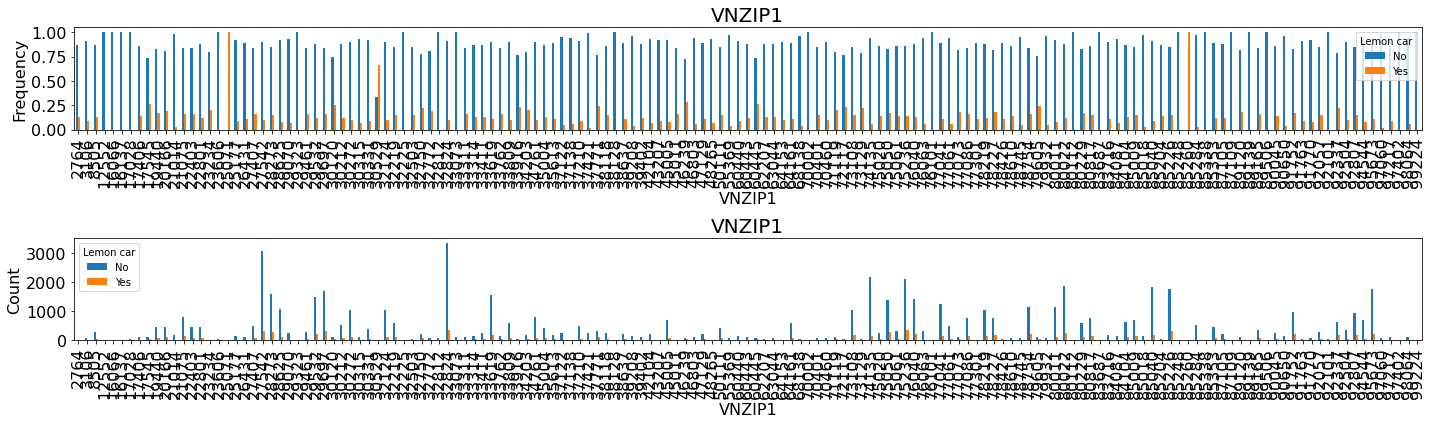

In [43]:
simpleBarPlot(df_train,'VNZIP1',2,1,'VNZIP1')

#### State where the the car was purchased

VNST,AL,AR,AZ,CA,CO,FL,GA,IA,ID,IL,IN,KY,LA,MA,MD,MI,MN,MO,MS,NC,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WV
IsBadBuy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,602,54,5470,6144,4394,9305,2177,426,177,391,418,215,297,13,993,13,60,676,447,6243,25,88,277,210,472,6,728,3263,198,700,3686,1561,11719,769,1399,128,263
1,88,16,704,951,604,1142,273,73,19,67,68,15,52,2,165,1,2,82,46,799,1,9,40,29,90,0,67,331,13,147,594,203,1877,106,263,8,29



################# Plot  VNST  #################

################# Number of unique values:  37 #################



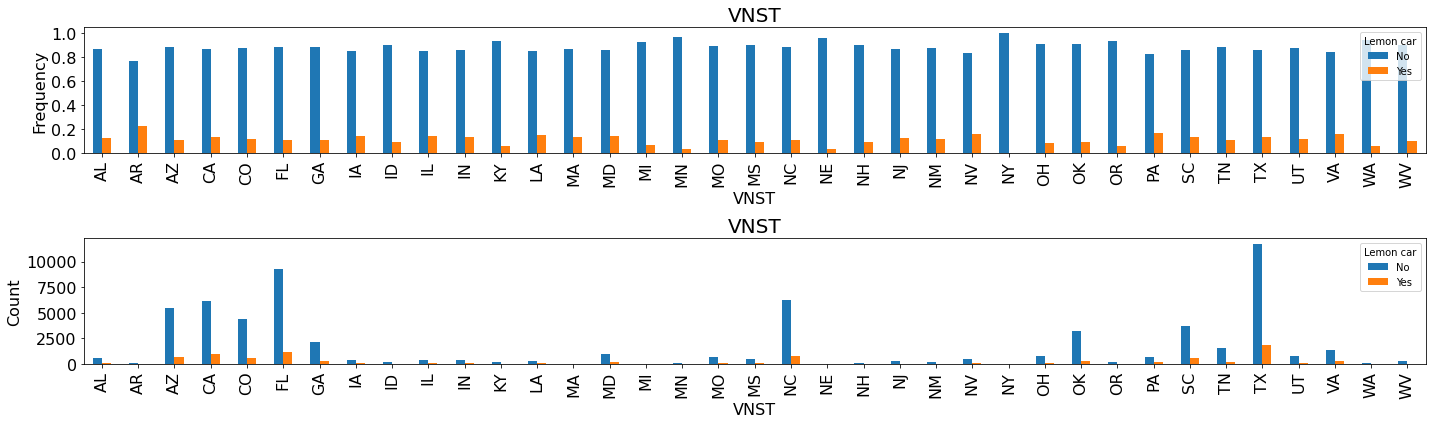

In [44]:
simpleBarPlot(df_train,'VNST',2,1,'VNST')

In [45]:
# Update drop_cols data frame
drop_cols = dropRemarks(drop_cols,'VNZIP1','Too many distinct values ')
drop_cols = dropRemarks(drop_cols,'PurchDate','Too many distinct values ')

drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"
MMRCurrentAuctionCleanPrice,About 99% correlation with MMRCurrentAuctionAv...


### Acquisition cost paid for the vehicle at time of purchase

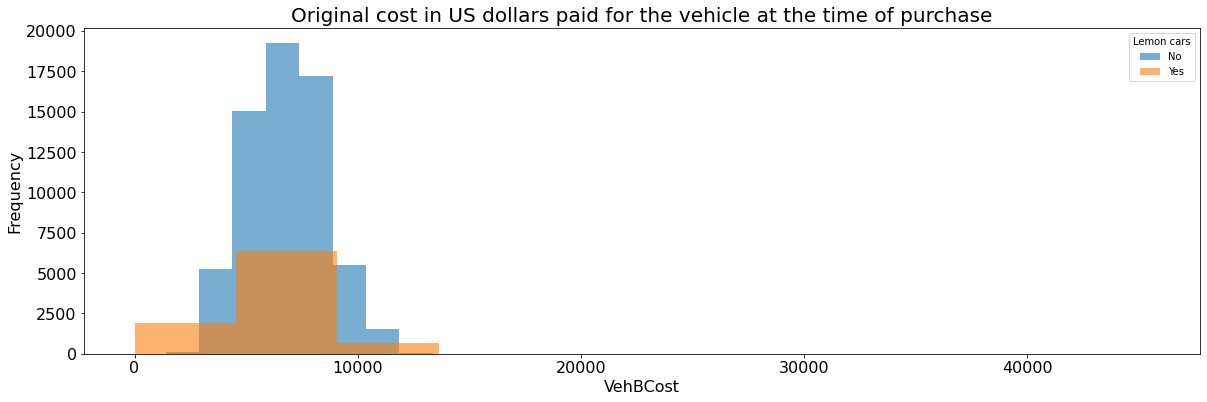

In [46]:
simpleHistPlot(df_train,'VehBCost','Original cost in US dollars paid for the vehicle at the time of purchase',False)

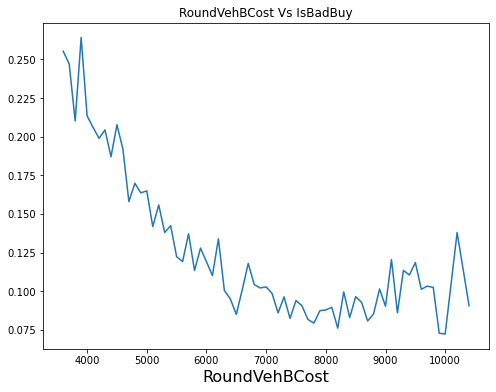

In [47]:
# create new variable essentially rounding the vehicle cost to the last two digits
df_cost_bb = df_train[['VehBCost','IsBadBuy']]
df_cost_bb['RoundVehBCost'] = round(df_cost_bb['VehBCost'],-2)


# plot the rounded vehicle cost vs. IsBadBuy

plt.figure(figsize=(8,6))
df_cost_bb.groupby('RoundVehBCost').agg([np.mean,np.size])['IsBadBuy'].query('size > 250')['mean']\
                                   .plot(title = "RoundVehBCost Vs IsBadBuy");
plt.xlabel('RoundVehBCost', fontsize=16);

#### We see that, as intuitively expected, the vehicle age increases the probability of a car being a bad buy, while the vehicle cost decreases this probability.

### Identifies if the vehicle was originally purchased online

IsOnlineSale,0,1
IsBadBuy,,
0,62375,1632
1,8763,213



################# Plot  IsOnlineSale  #################

################# Number of unique values:  2 #################



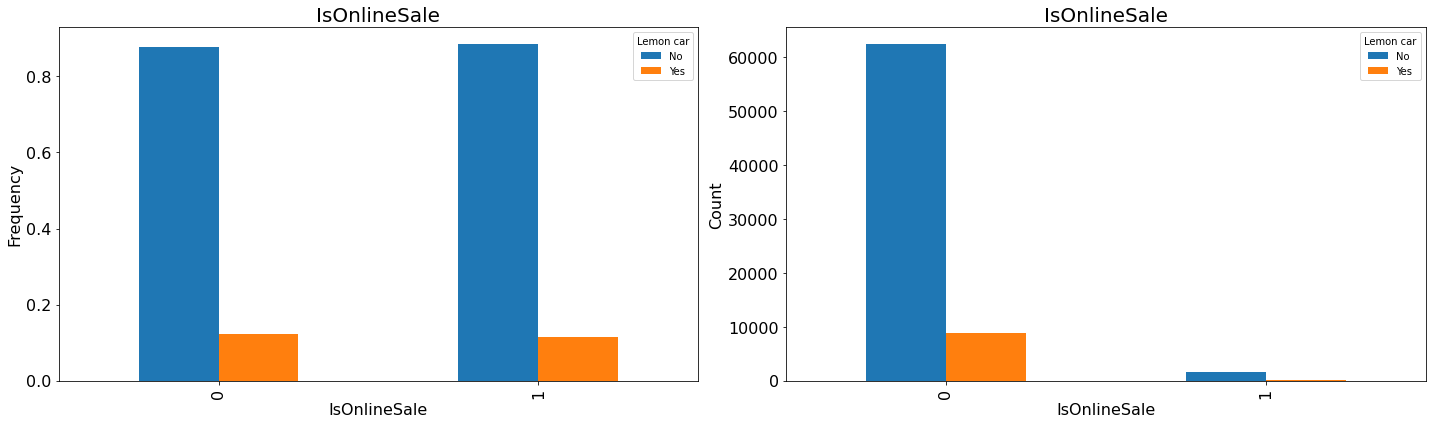

In [48]:
simpleBarPlot(df_train,'IsOnlineSale',1,2,'IsOnlineSale')

## Cost of the guarantee for a period of 36 months

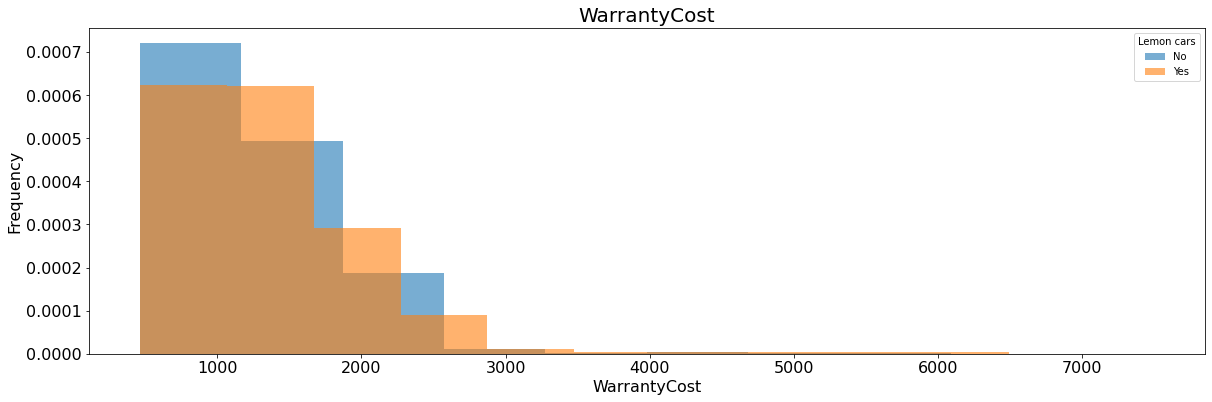

In [49]:
simpleHistPlot(df_train,'WarrantyCost','WarrantyCost',True)

### How are the numerical values distributed, are there outliers?

In [50]:
desired_num_cols = set(num_cols).difference(drop_cols.index.to_list())
desired_num_cols

{'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentRetailAveragePrice',
 'VehBCost',
 'VehOdo',
 'VehicleAge',
 'WarrantyCost'}

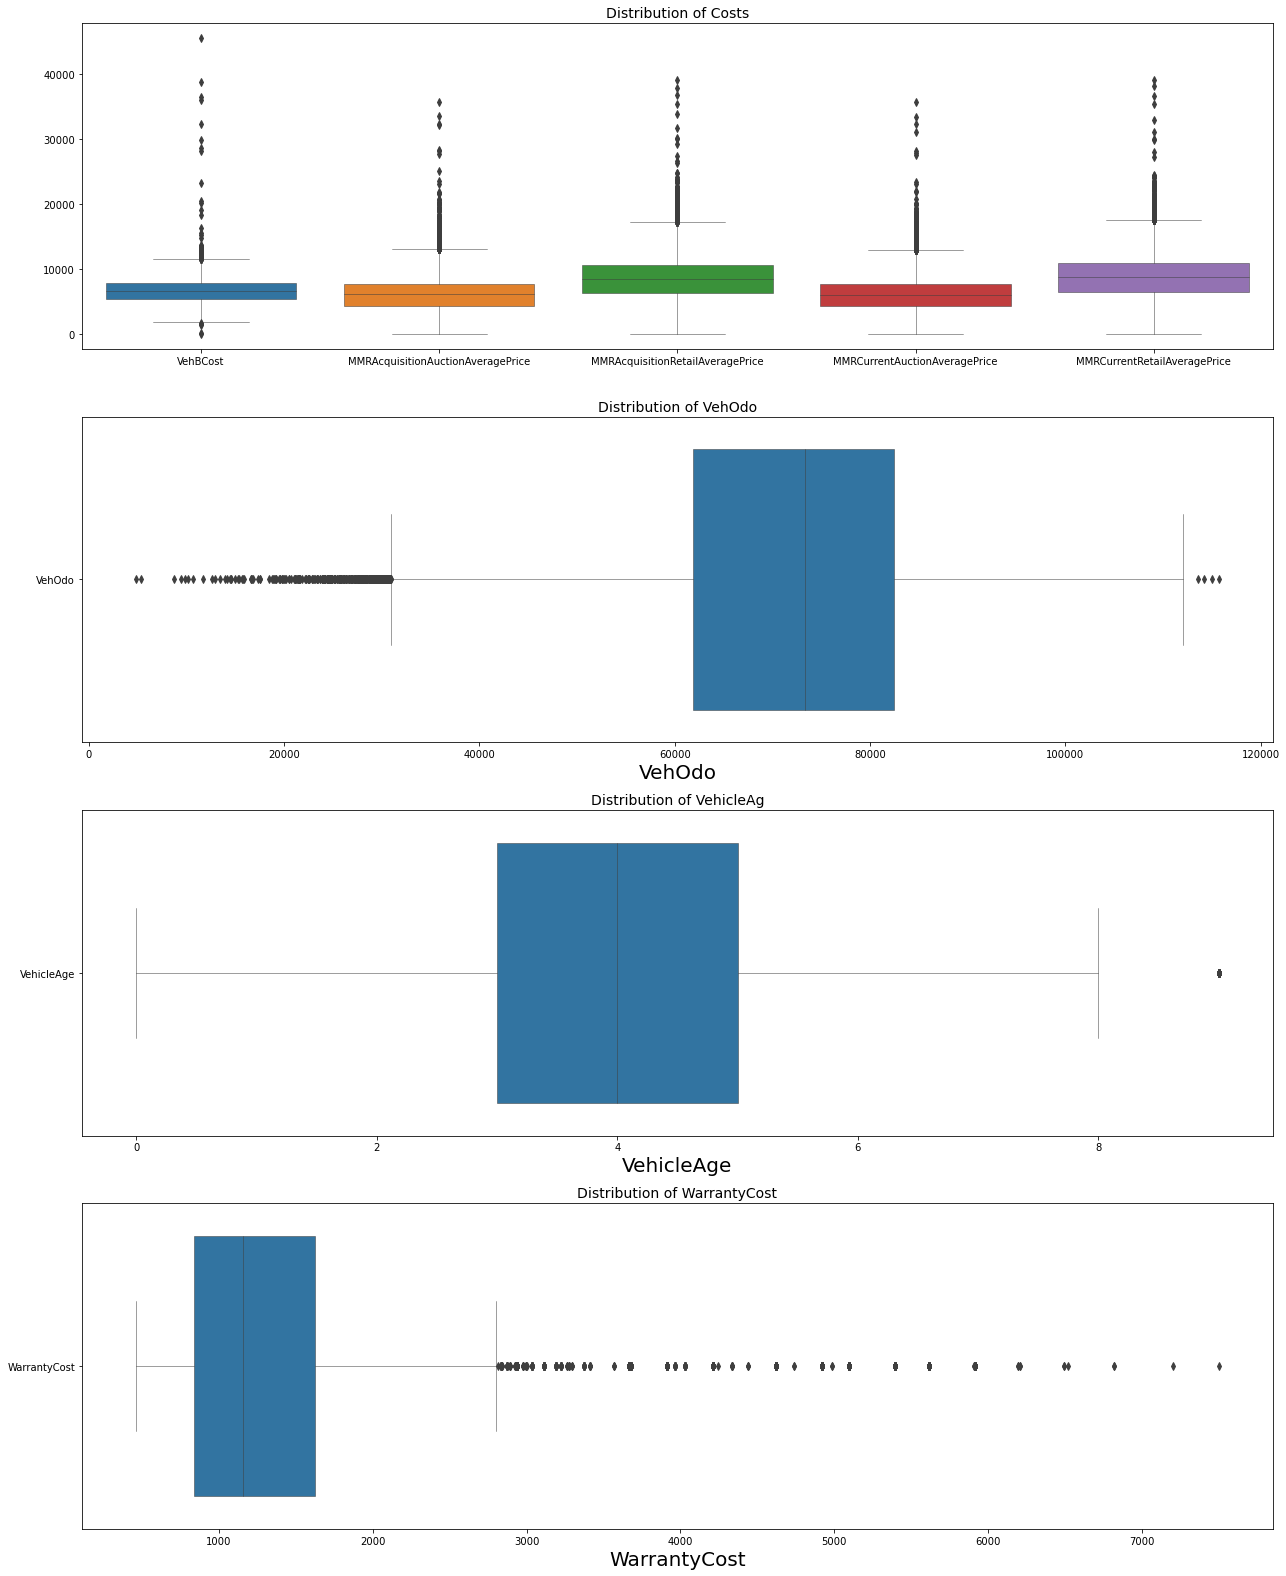

In [51]:
# Boxplots or histograms relevant columns
# Find outliers in data using a box plot
col1= ['VehBCost','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice','MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice']
col2 = ['VehOdo']
col3=['VehicleAge']
col4=['WarrantyCost']
fig, ax = plt.subplots(4,1,figsize=(18,22))
ax[0] = sns.boxplot(data=df_train[col1],linewidth=0.5, ax=ax[0]);
ax[0].set_title('Distribution of Costs', fontsize=14)

ax[1] = sns.boxplot(data=df_train[col2], orient="h",linewidth=0.5, ax=ax[1]);
# xtick, label, and title
ax[1].set_title('Distribution of VehOdo', fontsize=14)
ax[1].set_xlabel('VehOdo', fontsize=20)

ax[2] = sns.boxplot(data=df_train[col3], orient="h",linewidth=0.5, ax=ax[2]);
# xtick, label, and title
ax[2].set_title('Distribution of VehicleAg', fontsize=14)
ax[2].set_xlabel('VehicleAge', fontsize=20)


ax[3] = sns.boxplot(data=df_train[col4], orient="h",linewidth=0.5, ax=ax[3]);
# xtick, label, and title
ax[3].set_title('Distribution of WarrantyCost', fontsize=14)
ax[3].set_xlabel('WarrantyCost', fontsize=20)

plt.tight_layout();
sns.set(style="darkgrid")

# 5) Train Test Validation Split

#### In this project, we need both the training and the test and target data. Let's remember what each is good for. training data

#### * Trainingsdaten
    * Modell trainieren (model fitting)
    * Find the best hyperparameters with a grid search
    * Determine the model quality with cross-validation

#### * Testdaten
    * Evaluate the trained model

#### * Target dates
    * Use the trained model to predict target values where none are known

#### It is not specified the test data yet. Therefore, at this point, data is splited into a training and testing set and we proceed with the training set as if that were all the data you have available. When we have finished building the model, we can use the test set to simulate what happens when new data enters our data pipeline, for example new cars are offered on auction platforms.

In [52]:
# Perform train-test-split
from sklearn.model_selection import train_test_split


# Split off target from features
target = df_train.loc[:, 'IsBadBuy']
features = df_train.drop(columns=['IsBadBuy'])

# Set apart some data for testing
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            random_state=42, test_size=0.1)

#### We now have a training dataset. We can use this to create new features and to train the building blocks of your model.

# 6) Data Preparation

#### The goal of data preparation is to find a way to clean the data sets for our model (data cleaning) and to bring them into a format that the model can read (data type transformation). When these steps have been completed, we can set about selecting a training set that is as representative as possible (sampling).

In [53]:
# Copy created feature train and feature test for further comparision
features_train_init = features_train.copy()
features_test_init = features_test.copy()

In [54]:
# Descriptive statistics of features train dataset
features_train.describe()

,RefId,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,65684.00,65684.00,65684.00,62814.00,65684.00,65669.00,65669.00,65669.00,65669.00,65402.00,65402.00,65402.00,65402.00,65684.00,65684.00,65684.00,65684.00,65684.00
mean,36516.68,2005.34,4.18,1.49,71521.26,6127.69,7372.61,8497.09,9851.39,6132.10,7391.02,8775.87,10145.85,26301.94,58010.13,6729.65,0.03,1276.76
std,21097.19,1.73,1.71,0.52,14573.09,2460.01,2720.07,3154.23,3382.54,2435.06,2686.62,3088.38,3307.07,25669.85,26145.39,1764.63,0.16,598.65
min,1.00,2001.00,0.00,0.00,4825.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,835.00,2764.00,1.00,0.00,462.00
25%,18235.75,2004.00,3.00,1.00,61886.75,4273.00,5405.00,6278.00,7492.00,4274.00,5411.00,6539.00,7786.00,17212.00,32124.00,5435.00,0.00,837.00
50%,36508.00,2005.00,4.00,1.00,73399.50,6094.00,7303.00,8439.00,9788.00,6061.50,7314.00,8723.00,10103.00,19662.00,73108.00,6700.00,0.00,1169.00
75%,54829.25,2007.00,5.00,2.00,82460.00,7761.00,9018.00,10652.00,12088.00,7734.00,9012.75,10906.00,12308.00,22808.00,80022.00,7900.00,0.00,1623.00
max,73014.00,2010.00,9.00,3.00,115717.00,35722.00,36859.00,39080.00,41482.00,35722.00,36859.00,39080.00,41062.00,99761.00,99224.00,38785.00,1.00,7498.00


#### We can reduce the memory required by changing the dtype of the columns of a pandas DataFrame. For example, by default integers are stored as 'int64'. If we convert them to 'uint8', they only need an eighth of the original storage space. ('uint8' can represent values from 0 to 255 and 'uint16' already values up to 65535).

# 7) Data Imputation

#### As can be seen from EDA part, there are relatively many missing values in the data. This also applies to the test and target data. For the test and target data, we should classify each data point. So we should not remove a data point from them because of missing or improbable values. Instead, we could replace the missing values or remove features with many missing values.

In [55]:
percent_missing = features_train.isnull().sum() * 100 / len(features_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
PRIMEUNIT,95.32
AUCGUART,95.32
WheelType,4.38
WheelTypeID,4.37
Trim,3.25
MMRCurrentAuctionCleanPrice,0.43
MMRCurrentAuctionAveragePrice,0.43
MMRCurrentRetailCleanPrice,0.43
MMRCurrentRetailAveragePrice,0.43
MMRAcquisitionAuctionAveragePrice,0.02


In [56]:
def clean_data(df_init,df,col,imput_value):
    '''
    Function clean_data does simple data imputation
    for categorical data.
    Input: Initial dataframe, dataframe(modified)
    column name, imputation value as string
    TODO: from sklearn.impute import SimpleImputer
    '''
    # Data Type Transformation
    if col == 'VehicleAge' or col == 'IsOnlineSale':
        df[col] = df[col].astype('uint8')
        return df       
    
    # Data Imputation
    display(df_init[col].unique())
    display(df_init[col].isnull().sum())

    if col== 'Transmission':
        df[col].replace("Manual", "MANUAL", inplace=True)
    df[col].fillna(value=imput_value,inplace=True)
    display(df[col].unique())
    display(df[col].isnull().sum())        
    return df  

In [57]:
def type_transform(df):
    '''
    Function type_transform tranforms data type for features defined
    as inside the function
    '''
    category_cols=["Auction", "Make", "WheelType", "Transmission", "Size",
    "IsOnlineSale", "Nationality", "TopThreeAmericanName","VNST"]
    for col in category_cols:
        df[col]=df[col].astype("category")        
        
    # Convert data type int64 to int8
    # int_cols = list(features_train.select_dtypes(include='int64'))
    # int8: -128 to 127	Signed 8-bit integer
    # Two columns whose data type can be trnasformed. See their plausibility ranges
    df['VehicleAge'] = df['VehicleAge'].astype('uint8')
    df['IsOnlineSale'] = df['IsOnlineSale'].astype('uint8')
    return df

In [58]:
def fillDataGaps(df,col):
    '''
    Function fillDataGaps fill data gaps (missing data)
    with the median value of the whole data.
    Input: 
        df: dataframe, 
        col: column name as string#
    Output: 
        df: Modified DataFrame 
    '''
    df[col] = df[col].fillna(df[col].median())
    
    return df     

In [59]:
def dropUndesiredFeatures(df,drop_cols):
    '''
    Function dropUndesiredFeatures drops undesired 
    columns from the DataFrame.
    Input:
        df: DataFrame
        drop_cols:DataFrame which provide information
        of columns needed to be droped.
    Output:
        df_cleaned: Cleanded DataFrame
    '''
    drop_cols_names = drop_cols.index.to_list()
    df_cleaned = df.drop(drop_cols_names,axis=1)
    return df_cleaned

In [60]:
drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"
MMRCurrentAuctionCleanPrice,About 99% correlation with MMRCurrentAuctionAv...


In [61]:
# Apply cleaning and data imputation
features_train = clean_data(features_train_init,features_train,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Nationality','OTHER')
features_train = fillDataGaps(features_train,'MMRAcquisitionAuctionAveragePrice')
features_train = fillDataGaps(features_train,'MMRAcquisitionRetailAveragePrice')
features_train = fillDataGaps(features_train,'MMRCurrentAuctionAveragePrice')
features_train = fillDataGaps(features_train,'MMRCurrentRetailAveragePrice')
features_train = fillDataGaps(features_train,'VehBCost')
features_train = type_transform(features_train)

# Apply data cleaning
features_train_cleaned = dropUndesiredFeatures(features_train,drop_cols)
display(drop_cols)
display(features_train_cleaned.isna().sum())
display(features_train_cleaned.head(),features_train_cleaned.info())
features_train_cleaned.shape

array(['OTHER', 'CHRYSLER', 'GM', 'FORD', nan], dtype=object)

4

array(['OTHER', 'CHRYSLER', 'GM', 'FORD'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['MEDIUM', 'MEDIUM SUV', 'LARGE', 'CROSSOVER', 'VAN', 'COMPACT',
       'LARGE SUV', 'SMALL SUV', 'SPECIALTY', 'LARGE TRUCK',
       'SMALL TRUCK', 'SPORTS', nan], dtype=object)

4

array(['MEDIUM', 'MEDIUM SUV', 'LARGE', 'CROSSOVER', 'VAN', 'COMPACT',
       'LARGE SUV', 'SMALL SUV', 'SPECIALTY', 'LARGE TRUCK',
       'SMALL TRUCK', 'SPORTS', 'SIZE_UNKNOWN'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['Alloy', 'Covers', nan, 'Special'], dtype=object)

2875

array(['Alloy', 'Covers', 'WHELLTYPE_UNKNOWN', 'Special'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['AUTO', 'MANUAL', nan, 'Manual'], dtype=object)

8

array(['AUTO', 'MANUAL', 'TRANSMISSION_UNKNOWN'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['TOP LINE ASIAN', 'OTHER ASIAN', 'AMERICAN', 'OTHER', nan],
      dtype=object)

4

array(['TOP LINE ASIAN', 'OTHER ASIAN', 'AMERICAN', 'OTHER'], dtype=object)

0

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...
Model,Too many distincts values
SubModel,Too many distincts values
VehYear,96% Correlation with VehicleAge
Trim,Too many distinct values
Color,The effect is too suspicious!
WheelTypeID,"Redundant, as WheelType is available!"
MMRCurrentAuctionCleanPrice,About 99% correlation with MMRCurrentAuctionAv...


Auction                              0
VehicleAge                           0
Make                                 0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionRetailAveragePrice     0
MMRCurrentAuctionAveragePrice        0
MMRCurrentRetailAveragePrice         0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65684 entries, 61024 to 15795
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Auction                            65684 non-null  category
 1   VehicleAge                         65684 non-null  uint8   
 2   Make                               65684 non-null  category
 3   Transmission                       65684 non-null  category
 4   WheelType                          65684 non-null  category
 5   VehOdo                             65684 non-null  int64   
 6   Nationality                        65684 non-null  category
 7   Size                               65684 non-null  category
 8   TopThreeAmericanName               65684 non-null  category
 9   MMRAcquisitionAuctionAveragePrice  65684 non-null  float64 
 10  MMRAcquisitionRetailAveragePrice   65684 non-null  float64 
 11  MMRCurrentAuctionAveragePrice      65

,Auction,VehicleAge,Make,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VNST,VehBCost,IsOnlineSale,WarrantyCost
61024,MANHEIM,3,TOYOTA,AUTO,Alloy,79395,TOP LINE ASIAN,MEDIUM,OTHER,11840.00,16245.00,11714.00,16123.00,MO,11015.00,0,569
24206,OTHER,4,ISUZU,AUTO,Alloy,79299,OTHER ASIAN,MEDIUM SUV,OTHER,8101.00,9249.00,7705.00,8821.00,SC,8100.00,0,1974
29172,OTHER,1,DODGE,AUTO,Alloy,47747,AMERICAN,MEDIUM,CHRYSLER,8435.00,9610.00,8802.00,10006.00,OK,7800.00,0,834
54965,MANHEIM,2,CHEVROLET,AUTO,Covers,80515,AMERICAN,LARGE,GM,6944.00,8000.00,7663.00,8776.00,OK,6670.00,0,2152
27016,MANHEIM,4,CHRYSLER,AUTO,Alloy,97088,AMERICAN,MEDIUM,CHRYSLER,4076.00,7181.00,4390.00,8029.00,TX,3660.00,0,1630


None

(65684, 17)

# 8) Deal with outliers

#### Are there impossible values that just need to be sorted out in the training set?

#### If you choose to delete outliers. Then only do this in the training set. And don't add this step to your pipeline or cleaning function. Otherwise, you may not be able to get a prediction for every value in features_aim at project completion.

In [62]:
# Identifying outliers and deal with them
# Outliers analysis
def find_outliers(df):
    '''
    Function find_outliers finds the outlires of data
    using statistical methos interquartile range (IQR)
    '''
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outlire_range = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outlire_range

In [63]:
# Find number of outliers, maximum and minimum
# value of it for each column
# Initialize data frame for collecting outliers
df_outliers = pd.DataFrame(index = ['Count','Max','Min'])
for col in num_cols:
    outliers = find_outliers(features_train[col])
    df_outliers.loc['Count',col] = len(outliers)
    df_outliers.loc['Max',col] = outliers.max()
    df_outliers.loc['Min',col] = outliers.min()
df_outliers    

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
Count,0.00,585.00,310.00,474.00,751.00,281.00,1123.00,532.00,1196.00,725.00,831.00,181.00,745.00
Max,NaN,9.00,115717.00,35722.00,36859.00,39080.00,41482.00,35722.00,36859.00,39080.00,41062.00,38785.00,7498.00
Min,NaN,9.00,4825.00,12992.00,14440.00,17217.00,0.00,12901.00,0.00,0.00,0.00,1.00,2815.00


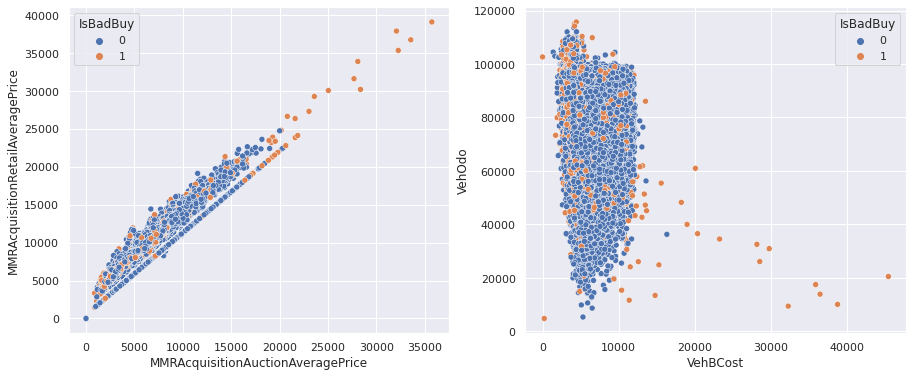

In [64]:
# Check for outliers
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.scatterplot(data=df_train, x = 'MMRAcquisitionAuctionAveragePrice',
                 y  = 'MMRAcquisitionRetailAveragePrice',hue="IsBadBuy",ax=ax[0]);
sns.scatterplot(x='VehBCost', y='VehOdo', data=df_train,  hue='IsBadBuy',ax=ax[1]);

#### Outliers visually detected in diagram Acquisition vs Odometer can not be droped as they are related to BadBays and these important information should be kept for our prediction later. 

# 9) Resample

#### As you may have noticed, the target categories in the dataset are very unbalanced. So it may be necessary to resample your training dataset.
#### Most machine learning algorithms assume that the data is evenly distributed within classes. In the case of class imbalance problems, the extensive issue is that the algorithm will be more biased towards predicting the majority class (no heart stroke in our case). The algorithm will not have enough data to learn the patterns present in the minority class (heart stroke).

col_0,count
IsBadBuy,
0,57542
1,8142


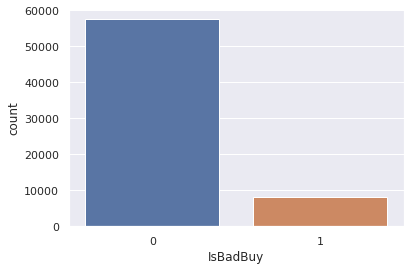

In [65]:
# Display the count of target value
display(pd.crosstab(index=target_train,
            columns='count'))
sns.countplot(target_train);

col_0,count
IsBadBuy,
0,57542
1,57542


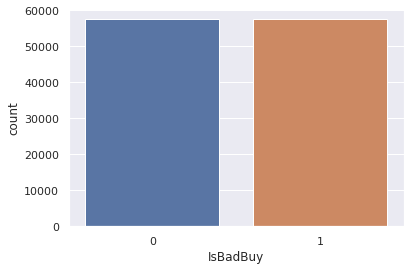

In [66]:
# Applay oversamoling to the train data
#1. initiatiate 
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

#2. fit and resample
features_train_cleaned, target_train = oversampler.fit_resample(features_train_cleaned, target_train)

#show classes
display(pd.crosstab(index=target_train,
            columns='count'))
sns.countplot(target_train);

# 10) Modeling
## Build a simple Baselinemodel


#### Before we devote yourself to the creation and selection of new features, we should first see from which point we start our efforts and create a first simple model without any hyperparameter optimization. This way we can always check afterwards whether the following steps in the model optimization bring an improvement. It is best to create a pipeline that not only models, but also encodes non-numerical features. 

In [86]:
# Import regured libraries for modeling and feature engineering steps.
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pdpipe as pdp

#useful imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel



In [68]:
# Apply data cleaning and imputation for features_test 
features_test = clean_data(features_test_init,features_test,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Nationality','OTHER')
print('--------------------------------------------------------------------------------------------')
features_test = fillDataGaps(features_test,'MMRAcquisitionAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRAcquisitionRetailAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentRetailAveragePrice')
features_test = fillDataGaps(features_test,'VehBCost')


features_test_cleaned = dropUndesiredFeatures(features_test,drop_cols)
display(features_test_cleaned.isna().sum())
display(features_test_cleaned.head(),features_test_cleaned.info())
features_test_cleaned = type_transform(features_test_cleaned)

array(['FORD', 'CHRYSLER', 'GM', 'OTHER', nan], dtype=object)

1

array(['FORD', 'CHRYSLER', 'GM', 'OTHER'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['VAN', 'MEDIUM SUV', 'CROSSOVER', 'MEDIUM', 'LARGE', 'SMALL SUV',
       'LARGE TRUCK', 'COMPACT', 'SPECIALTY', 'LARGE SUV', 'SPORTS',
       'SMALL TRUCK', nan], dtype=object)

1

array(['VAN', 'MEDIUM SUV', 'CROSSOVER', 'MEDIUM', 'LARGE', 'SMALL SUV',
       'LARGE TRUCK', 'COMPACT', 'SPECIALTY', 'LARGE SUV', 'SPORTS',
       'SMALL TRUCK', 'SIZE_UNKNOWN'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['Covers', 'Special', 'Alloy', nan], dtype=object)

299

array(['Covers', 'Special', 'Alloy', 'WHELLTYPE_UNKNOWN'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['AUTO', 'MANUAL', nan], dtype=object)

1

array(['AUTO', 'MANUAL', 'TRANSMISSION_UNKNOWN'], dtype=object)

0

--------------------------------------------------------------------------------------------


array(['AMERICAN', 'OTHER ASIAN', 'TOP LINE ASIAN', 'OTHER', nan],
      dtype=object)

1

array(['AMERICAN', 'OTHER ASIAN', 'TOP LINE ASIAN', 'OTHER'], dtype=object)

0

--------------------------------------------------------------------------------------------


Auction                              0
VehicleAge                           0
Make                                 0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionRetailAveragePrice     0
MMRCurrentAuctionAveragePrice        0
MMRCurrentRetailAveragePrice         0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7299 entries, 27851 to 46773
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Auction                            7299 non-null   object 
 1   VehicleAge                         7299 non-null   int64  
 2   Make                               7299 non-null   object 
 3   Transmission                       7299 non-null   object 
 4   WheelType                          7299 non-null   object 
 5   VehOdo                             7299 non-null   int64  
 6   Nationality                        7299 non-null   object 
 7   Size                               7299 non-null   object 
 8   TopThreeAmericanName               7299 non-null   object 
 9   MMRAcquisitionAuctionAveragePrice  7299 non-null   float64
 10  MMRAcquisitionRetailAveragePrice   7299 non-null   float64
 11  MMRCurrentAuctionAveragePrice      7299 non-null   

,Auction,VehicleAge,Make,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VNST,VehBCost,IsOnlineSale,WarrantyCost
27851,MANHEIM,6,FORD,AUTO,Covers,70008,AMERICAN,VAN,FORD,2677.00,3391.00,2554.00,3258.00,FL,4200.00,0,2157
51596,MANHEIM,5,FORD,AUTO,Special,84628,AMERICAN,MEDIUM SUV,FORD,5602.00,6550.00,6473.00,10117.00,CO,6800.00,0,1893
31933,OTHER,4,CHRYSLER,AUTO,Alloy,59369,AMERICAN,CROSSOVER,CHRYSLER,6902.00,7954.00,6600.00,7628.00,SC,8800.00,0,1086
12335,OTHER,3,PONTIAC,AUTO,Alloy,74180,AMERICAN,MEDIUM,GM,7371.00,8461.00,6528.00,7550.00,CA,7305.00,0,1272
68933,ADESA,3,MITSUBISHI,AUTO,Alloy,74783,OTHER ASIAN,MEDIUM SUV,OTHER,8916.00,10129.00,8236.00,11631.00,FL,8300.00,0,569


None

### 1- Define numeric features (num_cols) and categorical features (cat_cols)

In [69]:
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [70]:
num_cols =['VehicleAge','VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice',
           'MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice','VehBCost','WarrantyCost']

cat_cols = ['Auction','Make','Transmission','WheelType','Nationality','Size',
            'TopThreeAmericanName','VNST','IsOnlineSale']

# Define num_cols and cat_cols for base-model
num_cols_bl =['VehicleAge','VehOdo']
cat_cols_bl = ['Auction']

### 2- Select the algorithm for the baseline model and instantiate it as a model

In [71]:
features_train_cleaned[num_cols_bl+cat_cols_bl]

,VehicleAge,VehOdo,Auction
0,3,79395,MANHEIM
1,4,79299,OTHER
2,1,47747,OTHER
3,2,80515,MANHEIM
4,4,97088,MANHEIM
...,...,...,...
115079,2,71182,ADESA
115080,4,84193,OTHER
115081,6,63334,MANHEIM
115082,5,77752,OTHER


In [72]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(class_weight="balanced",max_iter=1000)

# Build pipeline
# Create preprocessing pipeline
preprocessor_baseline = ColumnTransformer([('num', StandardScaler(), num_cols_bl),
                                  ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols_bl)])
model_baseline = Pipeline([('pre', preprocessor_baseline),('clf', model_log)])

# fit pipeline on cleaned (and filtered) training set
model_baseline.fit(features_train_cleaned[num_cols_bl+cat_cols_bl], target_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['VehicleAge', 'VehOdo']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Auction'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [135]:
# predict and evaluate on test set
# features_train, features_test, target_train, target_test 
target_test_pred = model_baseline.predict(features_test_cleaned)
precision = precision_score(target_test, target_test_pred)
recall= recall_score(target_test, target_test_pred)
f1_scr = f1_score(target_test, target_test_pred)

scores = {'name': 'model_baseline_logreg',
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }

In [136]:
# Save model results
model_results=[]
model_results.append(scores)
model_results = pd.DataFrame(model_results)
model_results

,name,precision,recall,F1
0,model_baseline_logreg,0.17,0.60,0.27


# 11) Feature Engineering
## Dimensionality Reduction


In [75]:
def engineer_features_final(features,cols):
    '''
    Function OneHotEncoding
    '''   
      
    # OneHotEncoding train
    onehot = pdp.OneHotEncode(columns=cols, drop_first=False)
    features = onehot.fit_transform(features)
    
    return features

In [87]:
features_ohe= engineer_features_final(features_train_cleaned,cat_cols)
features_test_ohe = engineer_features_final(features_test_cleaned,cat_cols)
features_ohe

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VehBCost,WarrantyCost,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,Transmission_AUTO,Transmission_MANUAL,Transmission_TRANSMISSION_UNKNOWN,WheelType_Alloy,WheelType_Covers,WheelType_Special,WheelType_WHELLTYPE_UNKNOWN,Nationality_AMERICAN,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,Size_COMPACT,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SIZE_UNKNOWN,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,VNST_AL,VNST_AR,VNST_AZ,VNST_CA,VNST_CO,VNST_FL,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_NY,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV,IsOnlineSale_0,IsOnlineSale_1
0,3,79395,11840.00,16245.00,11714.00,16123.00,11015.00,569,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,79299,8101.00,9249.00,7705.00,8821.00,8100.00,1974,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,1,47747,8435.00,9610.00,8802.00,10006.00,7800.00,834,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,2,80515,6944.00,8000.00,7663.00,8776.00,6670.00,2152,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,4,97088,4076.00,7181.00,4390.00,8029.00,3660.00,1630,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115079,2,71182,6082.00,7069.00,5527.00,9322.00,4615.00,1389,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
115080,4,84193,6637.00,11157.00,6637.00,11157.00,8400.00,1373,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
115081,6,63334,6184.00,9436.00,6138.00,9346.00,7150.00,825,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [88]:
def scale_pca(features):
    '''
    Function scale_pca
    '''
    # Features with high correlation with eachother
    col_correlated = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice',
           'MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice','VehBCost']    
   
    keep_cols = [x for x in features.columns.tolist() if x not in col_correlated]
    std_pca = Pipeline([('std', StandardScaler()), ('pca', PCA(n_components=2))])  
    col_dropper = ColumnTransformer([('drop_unused_cols', 'passthrough', keep_cols)])
    # finalen Transformer definieren
    corr_transformer = ColumnTransformer(transformers=[('pca', std_pca, col_correlated)], remainder=col_dropper)
    # array erzeugen
    train_pca = corr_transformer.fit_transform(features)
    # Column names werden benötigt, um wieder ein Data Frame zu erzeugen
    col_names = ['price_cost_pca1','price_cost_pca2'] + keep_cols
    
    # ggf. Trainings-DF erzeugen
    features_pca = pd.DataFrame(train_pca, columns=col_names)     
    

    return features_pca

In [89]:
features_ohe_std_pca = scale_pca(features_ohe)
features_test_ohe_std_pca = scale_pca(features_test_ohe)
features_ohe_std_pca

,price_cost_pca1,price_cost_pca2,VehicleAge,VehOdo,WarrantyCost,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,Transmission_AUTO,Transmission_MANUAL,Transmission_TRANSMISSION_UNKNOWN,WheelType_Alloy,WheelType_Covers,WheelType_Special,WheelType_WHELLTYPE_UNKNOWN,Nationality_AMERICAN,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,Size_COMPACT,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SIZE_UNKNOWN,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,VNST_AL,VNST_AR,VNST_AZ,VNST_CA,VNST_CO,VNST_FL,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_NY,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV,IsOnlineSale_0,IsOnlineSale_1
0,5.34,0.11,3.00,79395.00,569.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.30,0.41,4.00,79299.00,1974.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.71,0.07,1.00,47747.00,834.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.59,-0.08,2.00,80515.00,2152.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-1.39,-1.07,4.00,97088.00,1630.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [90]:
# Difference due to different values orginated in train test split.. 
# For example in feature_test there is no nan value but in feature_train there nan.
drop_diff = features_ohe_std_pca.columns.difference(features_test_ohe_std_pca.columns).tolist()
features_ohe_std_pca.drop(drop_diff,axis=1,inplace=True)
features_ohe_std_pca.head()

,price_cost_pca1,price_cost_pca2,VehicleAge,VehOdo,WarrantyCost,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO,Transmission_AUTO,Transmission_MANUAL,Transmission_TRANSMISSION_UNKNOWN,WheelType_Alloy,WheelType_Covers,WheelType_Special,WheelType_WHELLTYPE_UNKNOWN,Nationality_AMERICAN,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,Size_COMPACT,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SIZE_UNKNOWN,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,VNST_AL,VNST_AR,VNST_AZ,VNST_CA,VNST_CO,VNST_FL,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV,IsOnlineSale_0,IsOnlineSale_1
0,5.34,0.11,3.00,79395.00,569.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.30,0.41,4.00,79299.00,1974.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.71,0.07,1.00,47747.00,834.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.59,-0.08,2.00,80515.00,2152.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-1.39,-1.07,4.00,97088.00,1630.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


# 12) Feature Selection
#### <a href="https://medium.com/fiverr-engineering/feature-selection-beyond-feature-importance-9b97e5a842f#:~:text=Why%20is%20it%20SO%20IMPORTANT%20to%20do%20Feature%20Selection%3F# /">Feature selection</a> is used to make the process more accurate. It also increases the prediction power of the algorithms by selecting the most critical variables and eliminating the redundant and irrelevant ones. This is why feature selection is important. Removing the noisy features will help with memory, computational cost and the accuracy of the model. Also, by removing features, it will help to avoid the overfitting of your model.

## Feature Selection Using Random forest


In [92]:
#initate Model
from sklearn.ensemble import RandomForestClassifier
model_rndforest = RandomForestClassifier(class_weight="balanced", random_state=0)

#fit
model_rndforest.fit(features_ohe_std_pca,target_train)

#save results
feature_results=[]

#predict
target_test_pred = model_rndforest.predict(features_test_ohe_std_pca)

#evaluate
recall = recall_score(target_test,target_test_pred)
precision = precision_score(target_test,target_test_pred)
f1_scr = f1_score(target_test,target_test_pred)

#save
scores = {'name': "model_rndforest",
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }
feature_results.append(scores)

#show results
feature_results = pd.DataFrame(feature_results)
feature_results

,name,precision,recall,F1
0,model_rndforest,0.59,0.27,0.38


## Feature importance using Meta-transformer based on importance weights

####  <a href="https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f">SelectFromModel</a> will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want.

,feature,importance
0,price_cost_pca1,0.15
3,VehOdo,0.14
1,price_cost_pca2,0.14
4,WarrantyCost,0.08
8,WheelType_WHELLTYPE_UNKNOWN,0.08
2,VehicleAge,0.07
7,WheelType_Covers,0.02
6,WheelType_Alloy,0.02
14,VNST_TX,0.01
5,Auction_MANHEIM,0.01


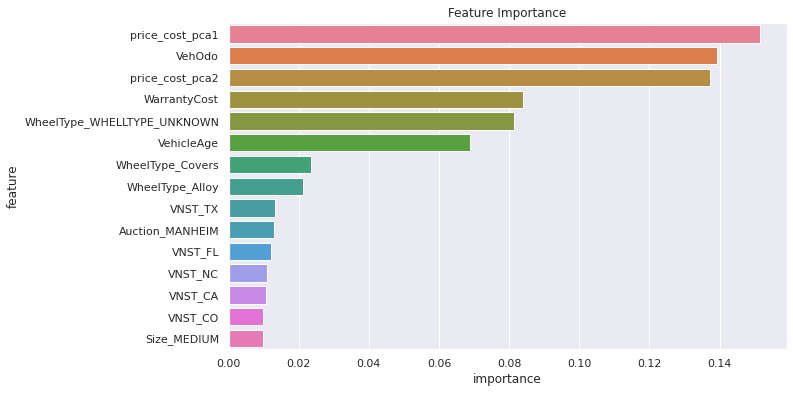

In [93]:
# ImportSelectFromModel as meta-transformer for selecting features based on importance weights.
# It automatically selects the features.

sel = SelectFromModel(model_rndforest)
sel.fit(features_ohe_std_pca, target_train)

# To see which features are important we can use get_support method on the fitted model.
# It will return an array of boolean values. True for the features whose importance
# is greater than the mean importance and False for the rest.
selected_feat = features_ohe_std_pca.columns[(sel.get_support())]
selected_imp_values  = sel.estimator_.feature_importances_[(sel.get_support())]
importance_df_sel = pd.DataFrame(selected_feat)

# Initialize important features data frame and plot them
importance_df = pd.DataFrame({
    'feature': selected_feat,
    'importance': selected_imp_values
}).sort_values('importance', ascending=False)

display(importance_df)
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df,palette='husl',x='importance', y='feature');

In [94]:
# feature_selection
features_ohe_std_pca_sel = features_ohe_std_pca[selected_feat]
features_test_ohe_std_pca_sel = features_test_ohe_std_pca[selected_feat]

In [95]:
#initate Model
from sklearn.ensemble import RandomForestClassifier
model_rndforest = RandomForestClassifier(class_weight="balanced", random_state=0)

#fit
model_rndforest.fit(features_ohe_std_pca_sel,target_train)

#predict
target_test_pred = model_rndforest.predict(features_test_ohe_std_pca_sel)

#evaluate
recall = recall_score(target_test,target_test_pred)
precision = precision_score(target_test,target_test_pred)
f1_scr = f1_score(target_test,target_test_pred)

#save
scores= {'name': "model_rndforest_selected_features",
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }
feature_results = feature_results.append(scores,ignore_index=True)

#show results
feature_results = feature_results.set_index('name')
feature_results

,precision,recall,F1
name,,,
model_rndforest,0.59,0.27,0.38
model_rndforest_selected_features,0.59,0.26,0.36


#### It seems that selecting just the first 15 important features did not improve the model scores. 

# 13) Train model
#### After preparing data and deciding on features we can proceed with building classification mdels.  
#### Building a model is an iterative process. Typically, we go through the following steps when choosing the model:
#### * Select features
#### * Scaling and dimension reduction (optional)
#### * Hyperparameter selection and training
#### * Validation of the model


In [96]:
# Modify columns names after PCA
num_cols =['VehicleAge','VehOdo','price_cost_pca1','price_cost_pca2','WarrantyCost']
cat_cols = ['Auction','Make','Transmission','WheelType','Nationality','Size',
            'TopThreeAmericanName','VNST','IsOnlineSale']

 ## Logistic Regression

In [97]:
# Initiate model
model_logreg = LogisticRegression(class_weight='balanced')

# Create Pipeline
pipeline_logreg = Pipeline([("scaler",StandardScaler()),
                           ("model_logreg", model_logreg)])

# Fit pipeline on cleaned training set
pipeline_logreg.fit(features_ohe_std_pca, target_train)

# Define hyperparameters range
# parameter grid, # l1 lasso l2 ridge
search_space_logreg = {
            'model_logreg__penalty' : ['l1','l2'], 
            'model_logreg__C'       : np.geomspace(0.001,1000,10),
            'model_logreg__solver'  : ['newton-cg', 'lbfgs'],
              }

# Perform grid search
grid_logreg = GridSearchCV(estimator=pipeline_logreg,
                            param_grid=search_space_logreg,
                            scoring='f1',
                            cv=3, n_jobs=-1)
grid_logreg.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_logreg)}:\n')
print(f'Mean (F1): {grid_logreg.best_score_}')
print(grid_logreg.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_logreg.best_params_)

Training F1-scores for <class 'sklearn.linear_model._logistic.LogisticRegression'>:

Mean (F1): 0.6554632947200725
Pipeline(steps=[('scaler', StandardScaler()),
                ('model_logreg',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    solver='newton-cg'))])
---
tuned hpyerparameters :(best parameters)  {'model_logreg__C': 0.001, 'model_logreg__penalty': 'l2', 'model_logreg__solver': 'newton-cg'}


In [98]:
print(f'Training F1-scores for {type(model_logreg)}:\n')
print(f'Mean (F1): {grid_logreg.best_score_}')
print(grid_logreg.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_logreg.best_params_)

Training F1-scores for <class 'sklearn.linear_model._logistic.LogisticRegression'>:

Mean (F1): 0.6554632947200725
Pipeline(steps=[('scaler', StandardScaler()),
                ('model_logreg',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    solver='newton-cg'))])
---
tuned hpyerparameters :(best parameters)  {'model_logreg__C': 0.001, 'model_logreg__penalty': 'l2', 'model_logreg__solver': 'newton-cg'}


## Random Forest Classifier

#### Please note that role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.Random Forest is a tree-based model and hence does not require feature scaling.

In [132]:
# Initiate model
model_randfst = RandomForestClassifier(class_weight='balanced',n_estimators=50, random_state=42)

# Define hyperparameters range
search_space_randfst = {"max_depth": [5, 8, 10, 15, 18, 20, 22, 23, 25, 28, 40],
                        "min_samples_leaf": [1, 3, 5, 7, 10, 50, 100, 200]}

# Perform grid search
grid_randfst = GridSearchCV(estimator=model_randfst,
                        param_grid=search_space_randfst,
                        scoring='f1',
                        cv=5) 
grid_randfst.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_randfst)}:\n')
print(f'Mean (F1): {grid_randfst.best_score_}')
print(grid_randfst.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_randfst.best_params_)   

Training F1-scores for <class 'sklearn.ensemble._forest.RandomForestClassifier'>:

Mean (F1): 0.9809964760193584
RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=50,
                       random_state=42)
---
tuned hpyerparameters :(best parameters)  {'max_depth': 40, 'min_samples_leaf': 1}


 ## KNeighborsClassifier

In [100]:
# Initiate model
model_knn = KNeighborsClassifier()

# Make Pipeline
pipeline_knn= Pipeline([("scaler",StandardScaler()),
                           ("model_knn", model_knn)])

# Define hyperparameters range
k = [1, 2, 4, 7, 11, 19, 31, 51, 84, 138, 227, 372]
search_space_knn = {'model_knn__n_neighbors': k,  
                    'model_knn__weights': ['uniform', 'distance'],
                     'model_knn__metric': ['euclidean','manhattan']}

# Perform grid search
grid_knn = GridSearchCV(estimator=pipeline_knn,
                        param_grid=search_space_knn,
                        scoring='f1',
                        cv=3,n_jobs = -1)
grid_knn.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_knn)}:\n')
print(f'Mean (F1): {grid_knn.best_score_}')
print(grid_knn.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_knn.best_params_)

Training F1-scores for <class 'sklearn.neighbors._classification.KNeighborsClassifier'>:

Mean (F1): 0.9392559392830369
Pipeline(steps=[('scaler', StandardScaler()),
                ('model_knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=1))])
---
tuned hpyerparameters :(best parameters)  {'model_knn__metric': 'manhattan', 'model_knn__n_neighbors': 1, 'model_knn__weights': 'uniform'}


# 14) Evaluate the best classification models
#### After using  the grid search to get an overview of which models are promising and how well they perform, we should evaluate them again with new test data. We can now use three model quality measures for this evaluation to examine our models in detail. 
#### We need to decide which metric is most important to us. We can use confusion_matrix() from sklearn.metrics to see exactly how many data points were correctly and incorrectly classified. 

### Again about the metrics:
#### With our understanding of the problem, we should now consider which metric(s) are best suited to assess the success of our model.
#### 1. Recall: Percentage of vehicles correctly predicted as lemon cars relative to all actual lemon cars.
#### 2. Precision: Percentage of vehicles correctly predicted as lemon cars relative to all correct predictions.
#### 3. F1 Score: Weighted harmonic mean of precision and recall.
#### Goal: Exclude as many bad purchases of "lemon cars" as possible. Minimize the false negative rate, i.e. the maximum recall.
#### However, this should not mean that too many good purchases are excluded (minimum false positive).
#### The false positive rate must not be too high either.
#### It is important to see which metric is most important to us. 
### <b style='color:blue !important;'>The f1 score takes into account both miss rates and is the metric we are looking for. Using confusion_matrix() as below, we      can see exactly how many data points were correctly and incorrectly classified.</b> 


Precision:  0.24268585131894485
Recall:  0.6067146282973621
F1:  0.3466940733127784

Precision:  0.5509708737864077
Recall:  0.27218225419664266
F1:  0.3643659711075441

Precision:  0.27578215527230593
Recall:  0.2853717026378897
F1:  0.2804949911608722


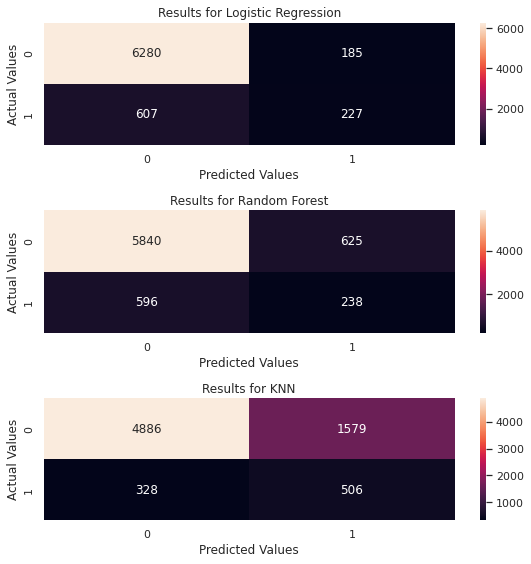

In [138]:
fig,ax = plt.subplots(nrows=3,figsize=(8,8))
model_names = ['Logistic Regression','Random Forest','KNN']

for n,clf in enumerate([grid_logreg, grid_randfst, grid_knn]):
    
    target_test_pred = clf.predict(features_test_ohe_std_pca)
    
    print('\nPrecision: ', precision_score(target_test, target_test_pred))
    print('Recall: ', recall_score(target_test, target_test_pred))
    print('F1: ', f1_score(target_test, target_test_pred))
    
    confusion_matrix_logreg = confusion_matrix(target_test, target_test_pred)
    sns.heatmap(confusion_matrix_logreg, annot=True, fmt='d', ax = ax[n-1]);
    ax[n-1].set(xlabel='Predicted Values', ylabel='Actual Values', title= 'Results for '+ model_names[n-1] );
    plt.tight_layout();


#### As can be seen from confusion matrix above, Random Forest Classifier has a better ability to classify the data showing better f1 score x% in comparision to other models. It also performs the most balanced precision and recall metrics. 

It can both recognize about half of the cars as lemon cars relative to all actual lemon cars (recall) as well as provides a percentage of cars correctly predicted as lemon cars relative to all correct predictions (precision).

The other two models are either better at recognizing the workforce that is leaving the company (higher recall value for model_log) or better at classifying only those who actually leave the company as such (higher precision model_rf).

In [140]:
# Saving a model
import joblib
#save your model or results
joblib.dump(model_baseline,'/kaggle/working/model_baseline.pkl')
joblib.dump(model_logreg, '/kaggle/working/grid_logreg.pkl')
joblib.dump(model_randfst, '/kaggle/working/grid_randfst.pkl')
#joblib.dump(model_dtree, 'model_dtree.pkl')
joblib.dump(model_knn, '/kaggle/working/grid_knn.pkl')
##load your model for further usage
#model_baseline = joblib.load("model_baseline.pkl")
#model_logreg = joblib.load("model_logreg.pkl")
#model_randfst = joblib.load("model_randfst.pkl")
#model_dtree = joblib.load("model_dtree.pkl")
#model_knn = joblib.load("model_knn.pkl")

['/kaggle/working/grid_knn.pkl']